# Análisis de Reducción de Dimensionalidad (PCA y UMAP) para Clasificación de Consumo de Drogas

## Descripción del Proyecto

Este notebook implementa técnicas de **reducción de dimensionalidad** (PCA y UMAP) para optimizar el rendimiento de modelos predictivos del nivel de riesgo de consumo de múltiples drogas. Se comparan los mejores modelos entrenados previamente (Ridge, Random Forest, SVR, KNN, Neural Network) antes y después de aplicar estas técnicas de reducción.

**Dataset:** Drug Consumption (UCI ML Repository)  
**Variables objetivo:** Nivel de consumo de 6 drogas (Cannabis, Cocaína, Heroína, Éxtasis, Benzodiacepinas, LSD)  
**Características:** Datos demográficos y rasgos de personalidad (Big Five, impulsividad, búsqueda de sensaciones)  
**Técnicas aplicadas:** PCA (Principal Component Analysis) y UMAP (Uniform Manifold Approximation and Projection)


In [ ]:
%pip install ucimlrepo --quiet
%pip install seaborn --quiet
%pip install scikit-learn --quiet
%pip install imblearn --quiet
%pip install imbalanced-learn --quiet
%pip install optuna --quiet
%pip install umap-learn --quiet

In [ ]:
# NN
!gdown 1XusXvhyBpgDPwwm6R9j_Ykwvw6yvsr33
# SVR
!gdown 1hjMm_6A7MHce8jSxFTcJ8ZS1bUhkTaBe
# RIDGE
!gdown 1waGIzFUPRFkf7j25jgEyDWVLEdLk3WjT
# RF
!gdown 1cYJjZRigF_Mm_qLV5f1gXP1ivixUMj6_
# KNNs
!gdown 1bbu5UzDZpIDHPDhPZ63scfojbro5dZoc
!gdown 1rPWzHZKxO9vvwT1Dzi5xWrQjapK2QE5O
!gdown 1Q2arbiqeA6i4JAjOx4nU4Ld7o432gWEu
!gdown 1iDosRBFm5yyYJJBVpDP1NNeG_IMvEBIQ
!gdown 1RL0kfuqtmS_Lw_KSv3n8gzpNiWCvEodI
!gdown 1TmKHJ5xdI497hOz2xICqioK9pTKXtA88

Downloading...
From: https://drive.google.com/uc?id=1XusXvhyBpgDPwwm6R9j_Ykwvw6yvsr33
To: /content/neural_net_weights.pth
100% 64.1k/64.1k [00:00<00:00, 14.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hjMm_6A7MHce8jSxFTcJ8ZS1bUhkTaBe
To: /content/svr_multi_full_range.pkl
100% 1.90M/1.90M [00:00<00:00, 33.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1waGIzFUPRFkf7j25jgEyDWVLEdLk3WjT
To: /content/ridge_multioutput_completo.pkl
100% 2.96k/2.96k [00:00<00:00, 7.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cYJjZRigF_Mm_qLV5f1gXP1ivixUMj6_
To: /content/rf_multi_optuna.pkl
100% 58.4M/58.4M [00:01<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bbu5UzDZpIDHPDhPZ63scfojbro5dZoc
To: /content/knn_lsd.pkl
100% 2.45M/2.45M [00:00<00:00, 42.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rPWzHZKxO9vvwT1Dzi5xWrQjapK2QE5O
To: /content/knn_ecstasy.pkl
100% 2.45M/2.45M [00:00<00:00, 62.5MB/s]
Downloading...
From: https://driv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_squared_log_error,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.samplers import TPESampler
import optuna.visualization as vis
import joblib
import os
import umap

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Carga y Preparación de Datos


### 1.1. Descripción del Dataset

El dataset Drug Consumption contiene información de 1885 individuos con las siguientes características:

**Características demográficas:**

- Edad, género, educación, país, etnia

**Rasgos de personalidad:**

- Neuroticismo, extraversión, apertura, amabilidad, responsabilidad, impulsividad, búsqueda de sensaciones

**Variables objetivo:**

- Nivel de consumo de diversas drogas codificado en 7 categorías (CL0 a CL6), donde CL0 representa "Nunca usado" y CL6 representa "Uso diario"


In [ ]:
print("=" * 70)
print("CARGA DE DATOS")
print("=" * 70)
print("\nDescargando dataset desde UCI ML Repository...")

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

# Corrección de nombres de columnas para consistencia
feature_map = {
    "nscore": "neuroticism",
    "escore": "extraversion",
    "oscore": "openness",
    "ascore": "agreeableness",
    "cscore": "conscientiousness",
    "impulsive": "impulsiveness",
    "ss": "sensation_seeking",
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "impulsiveness"
df.rename(columns=feature_map, inplace=True)

# Mapeo de categorías de consumo a valores numéricos
risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]

for drug in drugs:
    df[f"target_{drug}"] = df[drug].map(risk_map)

print(f"\nDataset cargado exitosamente")
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nDrogas analizadas: {', '.join([d.capitalize() for d in drugs])}")
print("=" * 70)

CARGA DE DATOS

Descargando dataset desde UCI ML Repository...

Dataset cargado exitosamente
Dimensiones: 1885 filas x 37 columnas

Drogas analizadas: Cannabis, Coke, Heroin, Ecstasy, Benzos, Lsd


## 2. Preprocesamiento y División de Datos


### 2.1. División Estratificada del Dataset


El dataset se divide en conjuntos de entrenamiento (80%) y prueba (20%) utilizando muestreo estratificado sobre la variable objetivo Heroína.

**Justificación de la estratificación por Heroína:**

- La heroína es la droga con menor frecuencia de consumo en el dataset
- Estratificar por esta variable asegura que ambos conjuntos contengan ejemplos de todas las clases
- Las drogas más comunes se distribuyen proporcionalmente por la Ley de los Grandes Números
- Previene que Train o Test queden sin ejemplos de clases minoritarias


In [ ]:
# Definir columnas de entrada (Features)
numeric_features = [
    "neuroticism",
    "extraversion",
    "openness",
    "agreeableness",
    "conscientiousness",
    "impulsiveness",
    "sensation_seeking",
    "age",
]
categorical_features = ["gender", "education", "country", "ethnicity"]

X = df[numeric_features + categorical_features]
y = df[[f"target_{d}" for d in drugs]]

# División 80/20 estratificada por Heroína
print("=" * 70)
print("DIVISIÓN DEL DATASET")
print("=" * 70)
print("\nAplicando split estratificado por 'target_heroin'...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["target_heroin"]
)

print(
    f"\nConjunto de entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)"
)
print(
    f"Conjunto de prueba:        {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)"
)
print("=" * 70)

DIVISIÓN DEL DATASET

Aplicando split estratificado por 'target_heroin'...

Conjunto de entrenamiento: 1,508 muestras (80.0%)
Conjunto de prueba:        377 muestras (20.0%)


### 2.2. Balanceo de Clases y Preprocesamiento


Para mitigar el problema de desbalanceo de clases, se aplica Random OverSampling (ROS) sobre el conjunto de entrenamiento. Esta técnica duplica aleatoriamente muestras de las clases minoritarias hasta equilibrar la distribución.

**Proceso de preprocesamiento:**

1. **Balanceo de clases:** Random OverSampling enfocado en la droga más difícil (heroína)
2. **Escalamiento:** StandardScaler para características numéricas (media 0, desviación estándar 1)
3. **Codificación:** OneHotEncoder para variables categóricas
4. **Aplicación:** El transformador se ajusta con datos balanceados y se aplica a train y test


In [ ]:
print("=" * 70)
print("BALANCEO DE CLASES")
print("=" * 70)
print("\nAplicando Random OverSampling...")

train_full = pd.concat([X_train, y_train], axis=1)

ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)

idx_res, y_res_ros = ros.fit_resample(
    np.array(train_full.index).reshape(-1, 1), y_train["target_heroin"]
)

train_balanced = train_full.loc[idx_res.flatten()]

X_train_bal = train_balanced[numeric_features + categorical_features]
y_train_bal = train_balanced[[f"target_{d}" for d in drugs]]

print(f"\nMuestras antes del balanceo:  {len(X_train):,}")
print(f"Muestras después del balanceo: {len(X_train_bal):,}")
print("=" * 70)

BALANCEO DE CLASES

Aplicando Random OverSampling...

Muestras antes del balanceo:  1,508
Muestras después del balanceo: 8,988


In [ ]:
print("=" * 70)
print("PREPROCESAMIENTO DE CARACTERÍSTICAS")
print("=" * 70)
print("\nAplicando ColumnTransformer...")
print("  - OneHotEncoder para variables categóricas")
print("  - StandardScaler para variables numéricas")

ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("scale", StandardScaler(), numeric_features),
    ]
)

X_train_proc = ct.fit_transform(X_train_bal)
X_test_proc = ct.transform(X_test)

print(f"\nDimensiones finales:")
print(f"  - X_train procesado: {X_train_proc.shape}")
print(f"  - X_test procesado:  {X_test_proc.shape}")
print("=" * 70)

PREPROCESAMIENTO DE CARACTERÍSTICAS

Aplicando ColumnTransformer...
  - OneHotEncoder para variables categóricas
  - StandardScaler para variables numéricas

Dimensiones finales:
  - X_train procesado: (8988, 33)
  - X_test procesado:  (377, 33)


## 3. Carga de Modelos Pre-entrenados


### 3.1. Definición de Arquitectura de Red Neuronal


In [ ]:
print("=" * 70)
print("CONFIGURACIÓN DE MODELOS")
print("=" * 70)

class RobustMultiTaskRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.4):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        self.heads = nn.ModuleDict(
            {drug: nn.Linear(hidden_dim // 2, 1) for drug in drugs}
        )

    def forward(self, x):
        feats = self.backbone(x)
        return {d: h(feats).view(-1) for d, h in self.heads.items()}


print("\nArquitectura de red neuronal definida")
print("=" * 70)

CONFIGURACIÓN DE MODELOS

Arquitectura de red neuronal definida


### 3.2 Carga de otros modelos

#### 3.2.1 Configuración de obtención de los modelos

In [ ]:
print("=" * 70)
print("CONFIGURACIÓN DE RUTAS DE MODELOS")
print("=" * 70)

paths = {
    "Random Forest": "./rf_multi_optuna.pkl",
    "SVR": "./svr_multi_full_range.pkl",
    "Ridge": "./ridge_multioutput_completo.pkl",
    "KNN_Folder": "./",
    "Neural Net": "./neural_net_weights.pth",
}

print("\nRutas configuradas:")
for name, path in paths.items():
    if name != "KNN_Folder":
        print(f"  - {name}: {path}")
print("=" * 70)

CONFIGURACIÓN DE RUTAS DE MODELOS

Rutas configuradas:
  - Random Forest: ./rf_multi_optuna.pkl
  - SVR: ./svr_multi_full_range.pkl
  - Ridge: ./ridge_multioutput_completo.pkl
  - Neural Net: ./neural_net_weights.pth


#### 3.2.2 Carga de los modelos

In [ ]:
print("=" * 70)
print("CARGA DE MODELOS PRE-ENTRENADOS")
print("=" * 70)

loaded_models = {}

# Cargar modelos de sklearn
for name in ["Random Forest", "SVR", "Ridge"]:
    try:
        if os.path.exists(paths[name]):
            loaded_models[name] = joblib.load(paths[name])
            print(f"\n{name} cargado exitosamente")
        else:
            print(f"\nAdvertencia: Archivo no encontrado para {name}: {paths[name]}")
    except Exception as e:
        print(f"\nError cargando {name}: {e}")

# Cargar Red Neuronal
try:
    nn_path = paths["Neural Net"]
    if os.path.exists(nn_path):
        input_dim = X_test_proc.shape[1]
        nn_model = RobustMultiTaskRegressor(input_dim=input_dim).to(device)
        nn_model.load_state_dict(torch.load(nn_path, map_location=device))
        nn_model.eval()
        loaded_models["Neural Net"] = nn_model
        print(f"\nRed Neuronal cargada exitosamente")
    else:
        print(f"\nAdvertencia: No se encontró el archivo: {nn_path}")
except NameError:
    print(
        "\nAdvertencia: Se necesita cargar X_test_proc antes de instanciar la red neuronal"
    )


# Wrapper para KNN
class KNNWrapper:
    def __init__(self, folder):
        self.models = {}
        for d in drugs:
            try:
                self.models[d] = joblib.load(f"{folder}/knn_{d}.pkl")
            except:
                pass

    def predict(self, X):
        preds = []
        for d in drugs:
            if d in self.models:
                p = self.models[d].predict(X)
                preds.append(p)
            else:
                preds.append(np.zeros(len(X)))
        return np.column_stack(preds)


# Cargar KNN
try:
    knn_wrapper = KNNWrapper(paths["KNN_Folder"])
    if len(knn_wrapper.models) > 0:
        loaded_models["KNN"] = knn_wrapper
        print(
            f"\nKNN cargado exitosamente ({len(knn_wrapper.models)} modelos individuales)"
        )
    else:
        print("\nAdvertencia: No se encontraron modelos KNN")
except Exception as e:
    print(f"\nError cargando KNN: {e}")

print("\n" + "=" * 70)

CARGA DE MODELOS PRE-ENTRENADOS

Random Forest cargado exitosamente

SVR cargado exitosamente

Ridge cargado exitosamente

Red Neuronal cargada exitosamente

KNN cargado exitosamente (6 modelos individuales)



### 3.3 Evaluación de modelos preentrenados para evaluación

#### 3.3.1 Evaluación inicial de los modelos cargados


In [ ]:
print("=" * 70)
print("EVALUACIÓN INICIAL DE MODELOS")
print("=" * 70)

comparison_data = []
y_test_eval = y_test

for name, model in loaded_models.items():
    print(f"\nEvaluando {name}...")

    preds_dict = {}

    try:
        if name == "Neural Net":
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X_test_proc).to(device)
                out = model(X_tensor)
                for d in drugs:
                    preds_dict[d] = out[d].view(-1).cpu().numpy()
        else:
            preds_matrix = model.predict(X_test_proc)
            for i, d in enumerate(drugs):
                preds_dict[d] = preds_matrix[:, i]

        # Cálculo de métricas
        rmses = []
        for drug in drugs:
            target_col = (
                f"target_{drug}" if f"target_{drug}" in y_test_eval.columns else drug
            )
            y_true = y_test_eval[target_col].values
            y_pred = preds_dict[drug]

            max_scale = 6
            y_pred = np.clip(y_pred, 0, max_scale)

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            rmses.append(rmse)

            comparison_data.append({"Modelo": name, "Droga": drug, "RMSE": rmse})

        print(f"  RMSE Promedio: {np.mean(rmses):.4f}")

    except Exception as e:
        print(f"  Error: {e}")

if len(comparison_data) > 0:
    df_results = pd.DataFrame(comparison_data)

    print("\n" + "=" * 70)
    print("RANKING FINAL (Menor RMSE gana)")
    print("=" * 70)
    ranking = df_results.groupby("Modelo")["RMSE"].mean().sort_values()
    print(ranking)

    top_2_names = ranking.index[:2].tolist()
    print(f"\nModelos seleccionados para análisis PCA/UMAP: {top_2_names}")
    print("=" * 70)
else:
    print("\nAdvertencia: No se generaron resultados")
    print("=" * 70)

EVALUACIÓN INICIAL DE MODELOS

Evaluando Random Forest...
  RMSE Promedio: 1.4804

Evaluando SVR...
  RMSE Promedio: 1.6190

Evaluando Ridge...
  RMSE Promedio: 1.7669

Evaluando Neural Net...
  RMSE Promedio: 1.5113

Evaluando KNN...
  RMSE Promedio: 1.6852

RANKING FINAL (Menor RMSE gana)
Modelo
Random Forest    1.480395
Neural Net       1.511329
SVR              1.619030
KNN              1.685222
Ridge            1.766877
Name: RMSE, dtype: float64

Modelos seleccionados para análisis PCA/UMAP: ['Random Forest', 'Neural Net']



GENERANDO CURVAS DE APRENDIZAJE (Todos los modelos compatibles)
Generando curva para: Random Forest...
  -> Random Forest: Listo.
Generando curva para: SVR...
  -> SVR: Listo.
Generando curva para: Ridge...
  -> Ridge: Listo.
Generando curva para: KNN...
  -> Error en KNN: The 'estimator' parameter of learning_curve must be an object implementing 'fit'. Got <__main__.KNNWrapper object at 0x7d8a9de53140> instead.


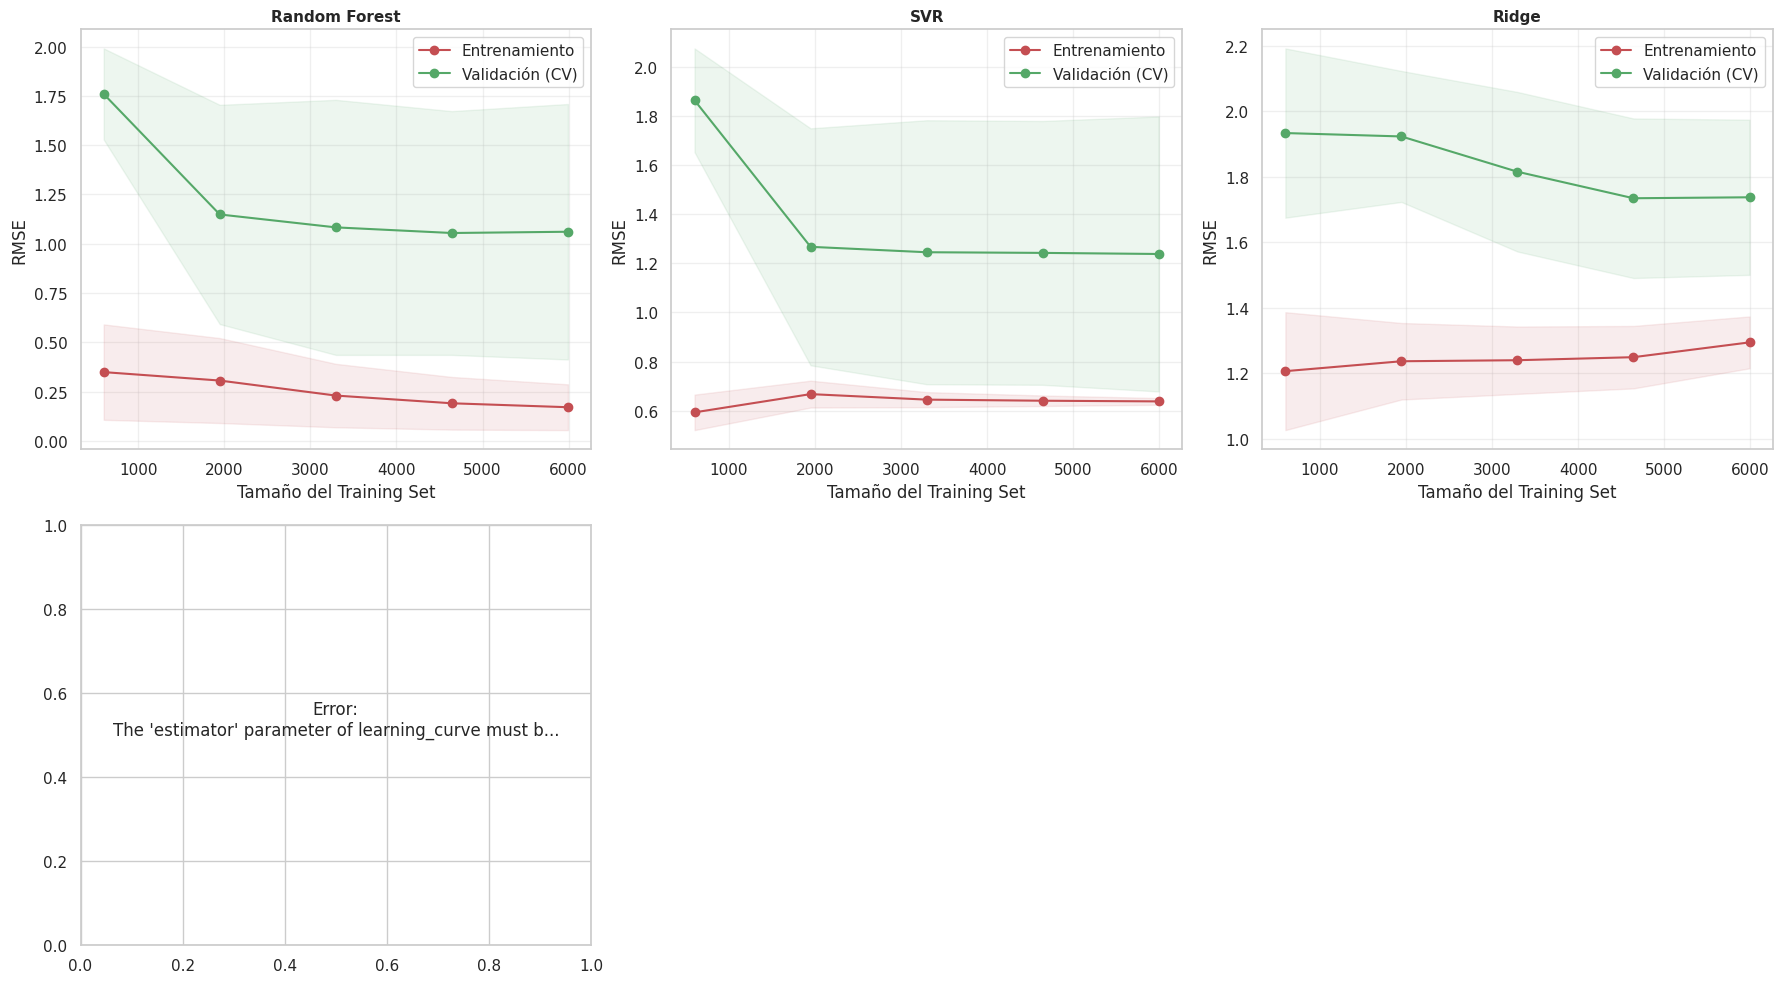

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import math

print("\n" + "=" * 70)
print("GENERANDO CURVAS DE APRENDIZAJE (Todos los modelos compatibles)")
print("=" * 70)

models_to_plot = [name for name in loaded_models.keys() if name != "Neural Net"]
n_models = len(models_to_plot)

if n_models == 0:
    print("Advertencia: No hay modelos compatibles para graficar.")
else:
    cols = 3 if n_models >= 3 else n_models
    rows = math.ceil(n_models / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    if n_models > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, name in enumerate(models_to_plot):
        print(f"Generando curva para: {name}...")
        ax = axes[idx]

        # Obtenemos el modelo
        model = loaded_models[name]

        try:
            # Calcular curva de aprendizaje
            train_sizes, train_scores, test_scores = learning_curve(
                estimator=model,
                X=X_train_proc,
                y=y_train_bal,
                cv=3,
                n_jobs=-1,
                train_sizes=np.linspace(0.1, 1.0, 5),
                scoring="neg_root_mean_squared_error"
            )

            # Procesar métricas (de negativo a positivo)
            train_rmse_mean = -np.mean(train_scores, axis=1)
            train_rmse_std = np.std(train_scores, axis=1)
            test_rmse_mean = -np.mean(test_scores, axis=1)
            test_rmse_std = np.std(test_scores, axis=1)

            # Graficar líneas
            ax.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Entrenamiento")
            ax.plot(train_sizes, test_rmse_mean, 'o-', color="g", label="Validación (CV)")

            # Graficar sombras (desviación estándar)
            ax.fill_between(train_sizes, train_rmse_mean - train_rmse_std,
                            train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
            ax.fill_between(train_sizes, test_rmse_mean - test_rmse_std,
                            test_rmse_mean + test_rmse_std, alpha=0.1, color="g")

            ax.set_title(name, fontweight="bold", fontsize=11)
            ax.set_xlabel("Tamaño del Training Set")
            ax.set_ylabel("RMSE")
            ax.legend(loc="best")
            ax.grid(True, alpha=0.3)

            print(f"  -> {name}: Listo.")

        except Exception as e:
            print(f"  -> Error en {name}: {e}")
            ax.text(0.5, 0.5, f"Error:\n{str(e)[:50]}...", ha='center')

    # 4. LIMPIEZA: Borrar ejes vacíos si sobran cuadros en la cuadrícula
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

print("=" * 70)

#### 3.3.2 Grafico de comparativa del error de los modelos por droga

GRÁFICO DE BARRAS: ERROR POR MODELO Y DROGA


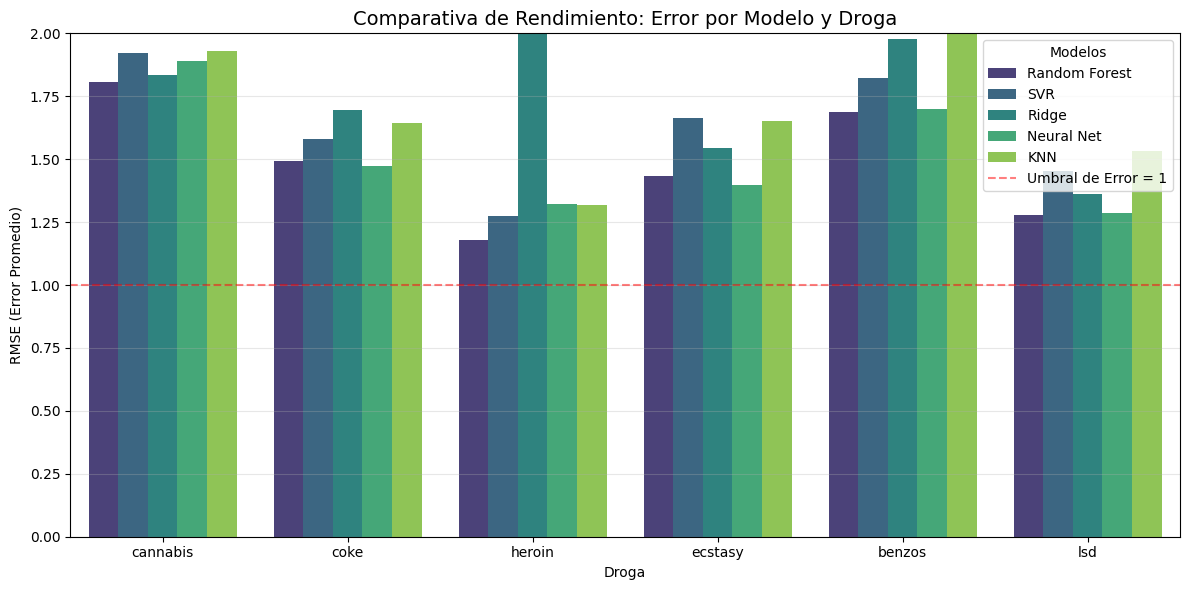

In [ ]:
print("=" * 70)
print("GRÁFICO DE BARRAS: ERROR POR MODELO Y DROGA")
print("=" * 70)

plt.figure(figsize=(12, 6))

# Gráfico de barras agrupado
sns.barplot(data=df_results, x="Droga", y="RMSE", hue="Modelo", palette="viridis")

plt.title("Comparativa de Rendimiento: Error por Modelo y Droga", fontsize=14)
plt.ylabel("RMSE (Error Promedio)")
plt.ylim(0, 2.0)
plt.axhline(1.0, color="red", linestyle="--", alpha=0.5, label="Umbral de Error = 1")
plt.legend(title="Modelos")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### 3.3.3 Grafico mapa de calor de modelos por droga

Mapa de calor que permite comparar el error de predicción (medido mediante RMSE) para cada combinación de modelo y droga. Para ello, los resultados se reorganizan en una tabla dinámica donde las filas corresponden a las diferentes drogas evaluadas, las columnas representan los modelos utilizados y cada celda contiene el valor del RMSE obtenido.

MAPA DE CALOR: ERROR POR MODELO Y DROGA


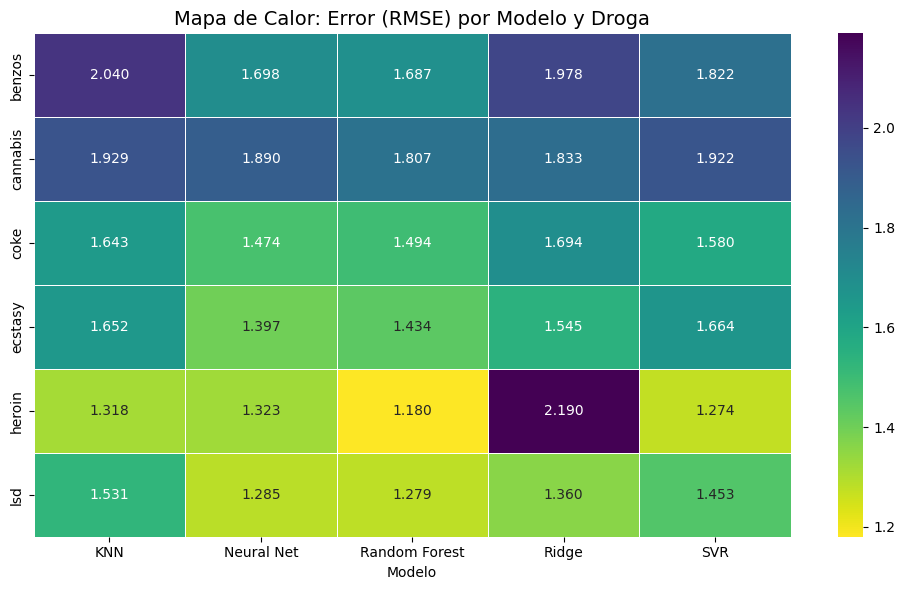

In [ ]:
print("=" * 70)
print("MAPA DE CALOR: ERROR POR MODELO Y DROGA")
print("=" * 70)

heatmap_data = df_results.pivot(index="Droga", columns="Modelo", values="RMSE")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis_r", linewidths=0.5)

plt.title("Mapa de Calor: Error (RMSE) por Modelo y Droga", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

#### 3.3.4 Evaluación para metrica de RMSLE

## Evaluación de Modelos con Métrica RMSLE

Evaluación comparativa de varios modelos utilizando la métrica RMSLE (Root Mean Squared Logarithmic Error). Para cada modelo cargado, se generan las predicciones correspondientes para todas las drogas. En el caso de la red neuronal, las predicciones se obtienen directamente desde el tensor de salida; para los demás modelos, se emplea la matriz predicha por el estimador.

Posteriormente, para cada droga se calcula el RMSE y el RMSLE entre los valores reales y predichos, aplicando un recorte de valores para mantener las predicciones dentro del rango permitido (0 a 6). Cada métrica se almacena en una estructura que permite construir un DataFrame consolidado con los resultados de todos los modelos y drogas.

Finalmente, se genera un ranking global ordenado por el RMSLE promedio de cada modelo, permitiendo identificar cuáles obtienen el mejor desempeño. A partir de este ranking, se seleccionan los dos modelos con menor RMSLE para su uso posterior en la fase basada en PCA.


In [ ]:
print("=" * 70)
print("EVALUACIÓN CON MÉTRICA RMSLE")
print("=" * 70)

comparison_data = []
y_test_eval = y_test

for name, model in loaded_models.items():
    print(f"\nEvaluando {name}...")

    preds_dict = {}

    try:
        if name == "Neural Net":
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X_test_proc).to(device)
                out = model(X_tensor)
                for d in drugs:
                    preds_dict[d] = out[d].view(-1).cpu().numpy()
        else:
            preds_matrix = model.predict(X_test_proc)
            for i, d in enumerate(drugs):
                preds_dict[d] = preds_matrix[:, i]

        # Cálculo de métricas por droga
        model_rmsles = []

        for drug in drugs:
            target_col = (
                f"target_{drug}" if f"target_{drug}" in y_test_eval.columns else drug
            )
            y_true = y_test_eval[target_col].values
            y_pred = preds_dict[drug]

            y_pred = np.clip(y_pred, 0, 6)

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
            model_rmsles.append(rmsle)

            comparison_data.append(
                {"Modelo": name, "Droga": drug, "RMSE": rmse, "RMSLE": rmsle}
            )

        print(f"  RMSLE Promedio: {np.mean(model_rmsles):.4f}")

    except Exception as e:
        print(f"  Error: {e}")

df_results = pd.DataFrame(comparison_data)

print("\n" + "=" * 70)
print("RANKING GLOBAL (Menor RMSLE)")
print("=" * 70)

ranking = df_results.groupby("Modelo")[["RMSLE", "RMSE"]].mean().sort_values("RMSLE")
print(ranking)

top_2_models = ranking.index[:2].tolist()
print(f"\nModelos seleccionados para fase PCA: {top_2_models}")
print("=" * 70)

EVALUACIÓN CON MÉTRICA RMSLE

Evaluando Random Forest...
  RMSLE Promedio: 0.6201

Evaluando SVR...
  RMSLE Promedio: 0.6691

Evaluando Ridge...
  RMSLE Promedio: 0.7870

Evaluando Neural Net...
  RMSLE Promedio: 0.6667

Evaluando KNN...
  RMSLE Promedio: 0.6868

RANKING GLOBAL (Menor RMSLE)
                  RMSLE      RMSE
Modelo                           
Random Forest  0.620062  1.480395
Neural Net     0.666680  1.511329
SVR            0.669094  1.619030
KNN            0.686796  1.685222
Ridge          0.786969  1.766877

Modelos seleccionados para fase PCA: ['Random Forest', 'Neural Net']


#### 3.3.5 Grafico de comparativa RMSLE y RMSE

Dos gráficas de barras que comparan el rendimiento de los modelos usando las métricas RMSLE y RMSE. La primera visualiza el error logarítmico por droga y modelo, mientras que la segunda muestra el error estándar. Ambas permiten observar diferencias de desempeño entre los modelos evaluados.


COMPARATIVA DE RMSLE Y RMSE

Generando gráfica de RMSLE...


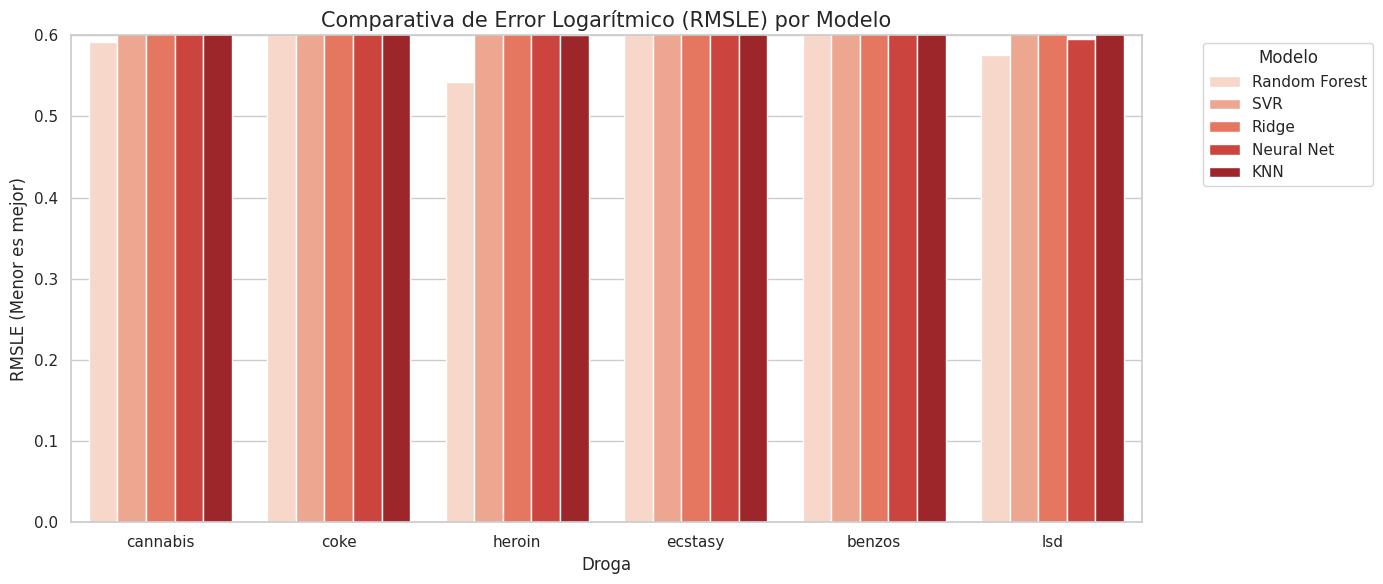


Generando gráfica de RMSE...


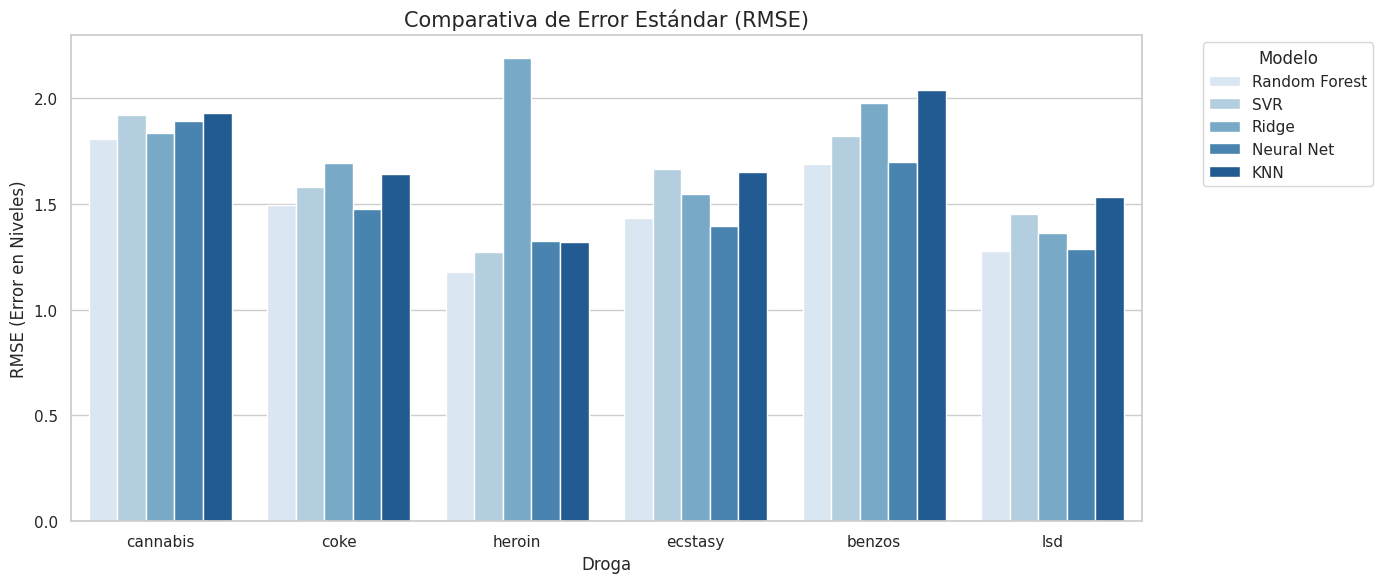

In [ ]:
print("=" * 70)
print("COMPARATIVA DE RMSLE Y RMSE")
print("=" * 70)

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Gráfica de RMSLE
print("\nGenerando gráfica de RMSLE...")
plt.figure()
sns.barplot(data=df_results, x="Droga", y="RMSLE", hue="Modelo", palette="Reds")

plt.title("Comparativa de Error Logarítmico (RMSLE) por Modelo", fontsize=15)
plt.ylabel("RMSLE (Menor es mejor)", fontsize=12)
plt.xlabel("Droga", fontsize=12)
plt.ylim(0, 0.6)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Gráfica de RMSE
print("\nGenerando gráfica de RMSE...")
plt.figure()
sns.barplot(data=df_results, x="Droga", y="RMSE", hue="Modelo", palette="Blues")

plt.title("Comparativa de Error Estándar (RMSE)", fontsize=15)
plt.ylabel("RMSE (Error en Niveles)", fontsize=12)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### 3.3.6 Mapa de Calor RMSLE



Este bloque genera un mapa de calor que muestra los valores de RMSLE para cada combinación de modelo y droga. La visualización permite identificar rápidamente variaciones en el error y comparar el desempeño relativo de los modelos.


MAPA DE CALOR RMSLE


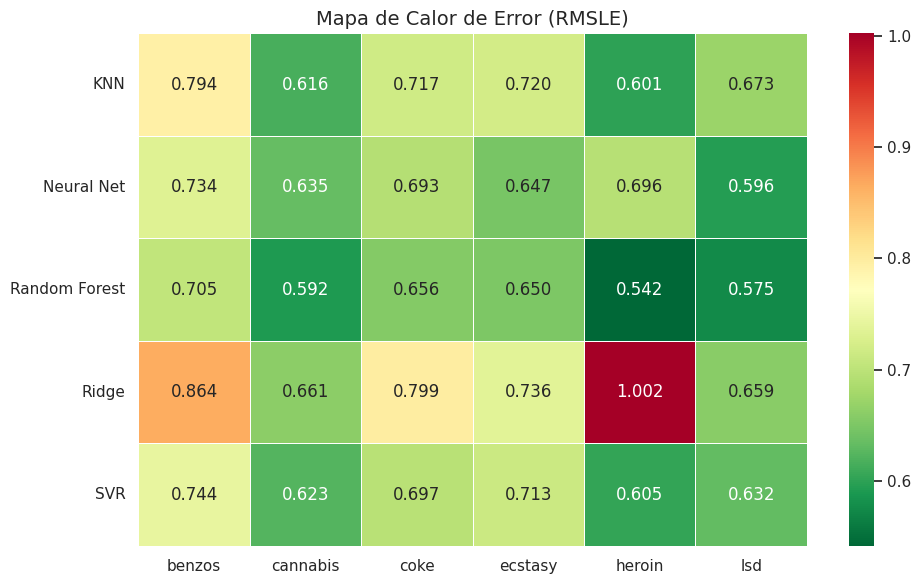

In [ ]:
print("=" * 70)
print("MAPA DE CALOR RMSLE")
print("=" * 70)

# Pivotear datos: Filas=Modelos, Columnas=Drogas
heatmap_data = df_results.pivot(index="Modelo", columns="Droga", values="RMSLE")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="RdYlGn_r", linewidths=0.5)

plt.title("Mapa de Calor de Error (RMSLE)", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#### 3.3.7 Gráfico Radar: Perfil de Rendimiento

Este bloque genera un gráfico radar que compara el rendimiento de los modelos según el RMSLE obtenido en cada droga. La visualización permite observar de forma conjunta el perfil de cada modelo y contrastar sus diferencias de manera intuitiva.








GRÁFICO RADAR: PERFIL DE RENDIMIENTO

Generando gráfico radar...


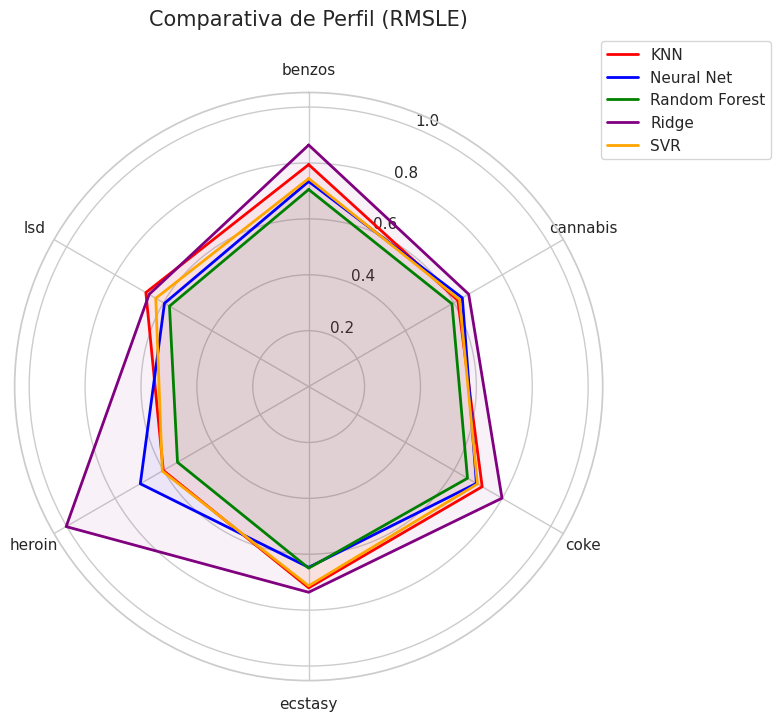

In [ ]:
print("=" * 70)
print("GRÁFICO RADAR: PERFIL DE RENDIMIENTO")
print("=" * 70)

def plot_radar(df, metric_col="RMSLE"):
    """
    Genera un gráfico radar para comparar el rendimiento de modelos

    Args:
        df: DataFrame con columnas Modelo, Droga y métrica
        metric_col: Nombre de la columna con la métrica a graficar
    """
    # Preparar datos
    pivot = df.pivot(index="Modelo", columns="Droga", values=metric_col)
    labels = pivot.columns.tolist()
    num_vars = len(labels)

    # Ángulos para el radar
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    colores = ["red", "blue", "green", "purple", "orange"]

    for i, (modelo, row) in enumerate(pivot.iterrows()):
        values = row.tolist()
        values += values[:1]  # Cerrar el círculo

        # Dibujar línea
        ax.plot(
            angles,
            values,
            linewidth=2,
            linestyle="solid",
            label=modelo,
            color=colores[i % len(colores)],
        )
        # Rellenar área
        ax.fill(angles, values, color=colores[i % len(colores)], alpha=0.05)

    # Etiquetas de los ejes
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=11)

    # Leyenda y título
    plt.title(f"Comparativa de Perfil ({metric_col})", fontsize=15, y=1.1)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    # Ejes radiales
    plt.ylim(0, pivot.max().max() + 0.05)
    plt.tight_layout()
    plt.show()


print("\nGenerando gráfico radar...")
plot_radar(df_results, "RMSLE")

## 4. Entrenamiento de Modelos Individuales

Esta sección contiene el código para entrenar modelos individuales si no se tienen modelos pre-entrenados disponibles.


### 4.1. Support Vector Regression (SVR)


Optimización de hiperparámetros con Optuna para SVR.


In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN DE SVR CON OPTUNA")
print("=" * 70)


def objective_svr(trial):
    """
    Función objetivo para optimización de hiperparámetros de SVR

    Args:
        trial: Objeto trial de Optuna

    Returns:
        float: Error RMSE promedio de validación cruzada
    """
    # Definir hiperparámetros a optimizar
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.01, 1.0)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Crear modelo SVR
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    model = MultiOutputRegressor(svr)

    # Validación cruzada
    scores = cross_val_score(
        model,
        X_train_proc,
        y_train_bal,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    return -scores.mean()


print("\nIniciando optimización de hiperparámetros...")
print("Este proceso puede tardar varios minutos...")
print("=" * 70)

### 4.2. Random Forest Regressor


In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN DE RANDOM FOREST CON OPTUNA")
print("=" * 70)


def objective(trial):
    """
    Función objetivo para optimización de hiperparámetros de Random Forest

    Args:
        trial: Objeto trial de Optuna

    Returns:
        float: Error RMSE promedio de validación cruzada
    """
    # Definir hiperparámetros a optimizar
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)

    # Crear modelo
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1,
    )

    model = MultiOutputRegressor(rf)

    # Validación cruzada
    scores = cross_val_score(
        model, X_train_proc, y_train_bal, cv=5, scoring="neg_root_mean_squared_error"
    )

    return -scores.mean()


# Ejecutar optimización
print("\nIniciando búsqueda de hiperparámetros óptimos...")
print("  - Trials a ejecutar: 50")
print("  - Método: Tree-structured Parzen Estimator (TPE)")
print("\nEsto puede tomar varios minutos...")
print("=" * 70)

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 70)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 70)
print(f"\nMejor RMSE encontrado: {study.best_value:.4f}")
print("\nMejores hiperparámetros:")
for param, value in study.best_params.items():
    print(f"  - {param}: {value}")

# Entrenar modelo final con mejores parámetros
print("\n" + "=" * 70)
print("ENTRENAMIENTO DEL MODELO OPTIMIZADO")
print("=" * 70)

best_params = study.best_params
final_rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42,
    n_jobs=-1,
)

final_model = MultiOutputRegressor(final_rf)
final_model.fit(X_train_proc, y_train_bal)

print("\nModelo optimizado entrenado exitosamente")
print("=" * 70)

### 4.3. K-Nearest Neighbors (KNN)


In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN DE KNN CON GRIDSEARCH")
print("=" * 70)
print("\nConfigurando GridSearchCV para KNN Regressor...")

# Definir espacio de búsqueda
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

print(f"\nEspacio de búsqueda:")
print(f"  - n_neighbors: {param_grid_knn['n_neighbors']}")
print(f"  - weights: {param_grid_knn['weights']}")
print(f"  - metric: {param_grid_knn['metric']}")
print(
    f"  - Total de combinaciones: {len(param_grid_knn['n_neighbors']) * len(param_grid_knn['weights']) * len(param_grid_knn['metric'])}"
)

results_knn_grid = []
best_knn_models = {}

print("\nIniciando búsqueda con validación cruzada (3-fold)...")
print("=" * 70)

for drug in drugs:
    print(f"\nOptimizando {drug.capitalize()}...", end=" ")

    y_tr = y_train_bal[f"target_{drug}"]
    y_ts = y_test[f"target_{drug}"]

    grid = GridSearchCV(
        KNeighborsRegressor(),
        param_grid_knn,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=0,
    )

    grid.fit(X_train_proc, y_tr)
    best_knn = grid.best_estimator_
    best_knn_models[drug] = best_knn

    # Predicción
    y_pred = best_knn.predict(X_test_proc)
    y_pred = np.clip(y_pred, 0, 6)

    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_ts, y_pred))
    mae = mean_absolute_error(y_ts, y_pred)

    # Métricas de clasificación
    y_pred_round = np.round(y_pred).astype(int)
    y_ts_int = y_ts.astype(int)

    report = classification_report(
        y_ts_int, y_pred_round, output_dict=True, zero_division=0
    )
    f1 = report["weighted avg"]["f1-score"]

    results_knn_grid.append(
        {
            "Droga": drug.capitalize(),
            "RMSE": rmse,
            "MAE": mae,
            "F1": f1,
            "Best_K": grid.best_params_["n_neighbors"],
            "Weights": grid.best_params_["weights"],
            "Metric": grid.best_params_["metric"],
        }
    )

    print(f"RMSE: {rmse:.4f} | Best K: {grid.best_params_['n_neighbors']}")

results_knn_df = pd.DataFrame(results_knn_grid)

print("\n" + "=" * 70)
print("RESULTADOS FINALES - KNN OPTIMIZADO")
print("=" * 70)
print(
    results_knn_df[["Droga", "RMSE", "F1", "Best_K", "Weights"]].to_string(index=False)
)
print("=" * 70)

### 4.4. Ridge Regression


In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN DE RIDGE REGRESSION CON GRIDSEARCH")
print("=" * 70)

# Definir modelo base
ridge = Ridge(random_state=42)
multi_ridge = MultiOutputRegressor(ridge)

# Definir espacio de búsqueda
param_grid = {
    "estimator__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100],
    "estimator__solver": ["auto", "svd", "cholesky", "lsqr"],
}

print(f"\nEspacio de búsqueda:")
print(f"  - Alpha: {param_grid['estimator__alpha']}")
print(f"  - Solver: {param_grid['estimator__solver']}")
print(
    f"  - Total de combinaciones: {len(param_grid['estimator__alpha']) * len(param_grid['estimator__solver'])}"
)

# Configurar GridSearchCV
grid = GridSearchCV(
    estimator=multi_ridge,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("\nIniciando búsqueda con validación cruzada (3-fold)...")
print("=" * 70)
grid.fit(X_train_proc, y_train_bal)

print("\n" + "=" * 70)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("=" * 70)
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor score (RMSE negativo): {grid.best_score_:.4f}")
print("=" * 70)

## 5. Análisis de Importancia de Características


### 5.1. Selección de Características


#### Análisis de Importancia de Características (Independiente)

Este bloque realiza un análisis de importancia de características utilizando dos enfoques: Random Forest y Mutual Information. Para cada droga, se entrena un modelo independiente aplicando un target encoding simple a las variables categóricas y luego se acumulan las importancias obtenidas.


ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (INDEPENDIENTE)
Calculando importancia promediada sobre todas las drogas...


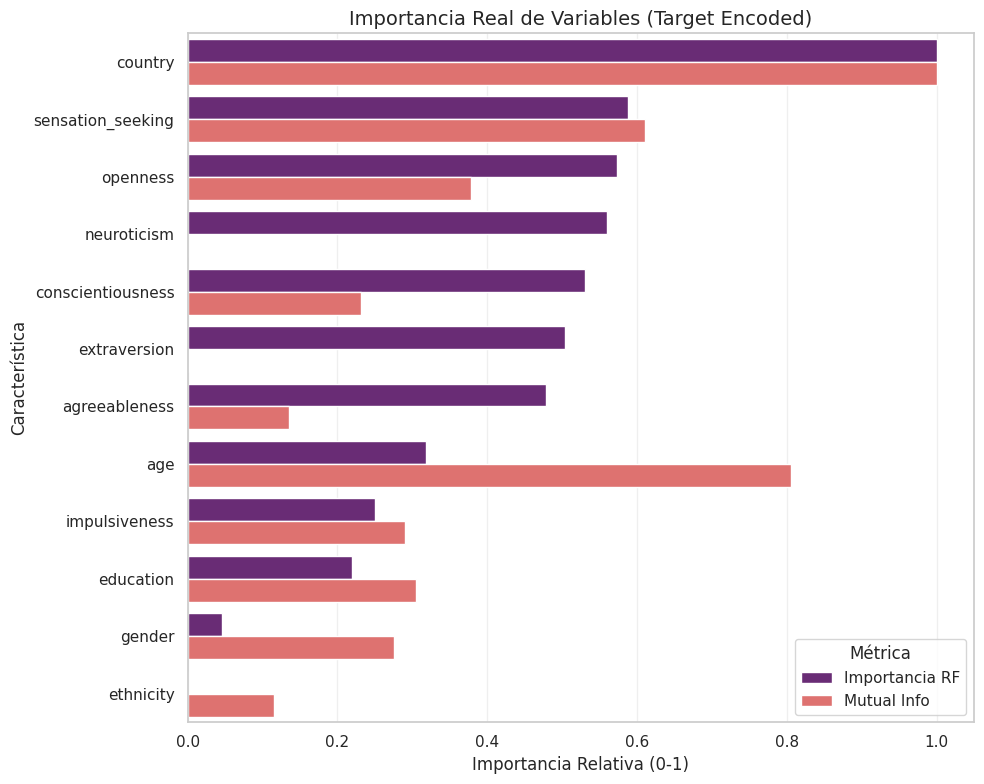


TABLA DE IMPORTANCIA DE VARIABLES (TOP 10)
   Característica  Importancia RF  Mutual Info
          country        1.000000     1.000000
sensation_seeking        0.588499     0.611151
         openness        0.573838     0.378822
      neuroticism        0.559676     0.000000
conscientiousness        0.530545     0.231687
     extraversion        0.504129     0.001172
    agreeableness        0.478630     0.134972
              age        0.317739     0.806071
    impulsiveness        0.250325     0.290579
        education        0.219174     0.305544


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

print("=" * 70)
print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (INDEPENDIENTE)")
print("=" * 70)

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

feature_map = {
    "nscore": "neuroticism",
    "escore": "extraversion",
    "oscore": "openness",
    "ascore": "agreeableness",
    "cscore": "conscientiousness",
    "impulsive": "impulsiveness",
    "ss": "sensation_seeking",
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "impulsiveness"
df.rename(columns=feature_map, inplace=True)

risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]
for d in drugs:
    df[f"target_{d}"] = df[d].map(risk_map)

numeric_features = ["neuroticism", "extraversion", "openness", "agreeableness",
                   "conscientiousness", "impulsiveness", "sensation_seeking", "age"]
categorical_features = ["gender", "education", "country", "ethnicity"]
feature_names = numeric_features + categorical_features

X = df[numeric_features + categorical_features].copy()

importances_rf = np.zeros(len(feature_names))
importances_mi = np.zeros(len(feature_names))
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Calculando importancia promediada sobre todas las drogas...")

for drug in drugs:
    y_target_temp = df[f"target_{drug}"]

    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y_target_temp, test_size=0.2, random_state=42, stratify=y_target_temp
    )

    X_train_encoded = X_train_temp.copy()

    for cat_col in categorical_features:
        encoding = y_train_temp.groupby(X_train_temp[cat_col]).mean()
        X_train_encoded[cat_col] = X_train_temp[cat_col].map(encoding).fillna(y_train_temp.mean())

    rf.fit(X_train_encoded, y_train_temp)
    importances_rf += rf.feature_importances_

    mi_scores = mutual_info_regression(X_train_encoded, y_train_temp, random_state=42)
    importances_mi += mi_scores

importances_rf /= len(drugs)
importances_mi /= len(drugs)

df_imp = pd.DataFrame({
    "Característica": feature_names,
    "Importancia RF": importances_rf,
    "Mutual Info": importances_mi
})

scaler = MinMaxScaler()
df_imp[["Importancia RF", "Mutual Info"]] = scaler.fit_transform(df_imp[["Importancia RF", "Mutual Info"]])
df_imp = df_imp.sort_values(by="Importancia RF", ascending=False)

plt.figure(figsize=(10, 8))
df_melted = df_imp.melt(id_vars="Característica", var_name="Métrica", value_name="Score Normalizado")
sns.barplot(data=df_melted, y="Característica", x="Score Normalizado", hue="Métrica", palette="magma")
plt.title("Importancia Real de Variables (Target Encoded)", fontsize=14)
plt.xlabel("Importancia Relativa (0-1)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("TABLA DE IMPORTANCIA DE VARIABLES (TOP 10)")
print("="*50)
print(df_imp.head(10).to_string(index=False))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

print("=" * 70)
print("ANÁLISIS DE IMPORTANCIA Y SELECCIÓN DE VARIABLES")
print("=" * 70)

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

feature_map = {
    "nscore": "Neuroticismo",
    "escore": "Extraversion",
    "oscore": "Apertura",
    "ascore": "Amabilidad",
    "cscore": "Responsabilidad",
    "impulsive": "Impulsividad",
    "ss": "Busqueda_Sensaciones",
    "age": "Edad",
    "gender": "Genero",
    "education": "Educacion",
    "country": "Pais",
    "ethnicity": "Etnia"
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "Impulsividad"
df.rename(columns=feature_map, inplace=True)

risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]
for d in drugs:
    df[f"target_{d}"] = df[d].map(risk_map)

feature_names = list(feature_map.values())
X = df[feature_names].copy()

importances_rf = np.zeros(len(feature_names))
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Calculando importancia de variables...")

for drug in drugs:
    y_target = df[f"target_{drug}"]

    X_encoded = X.copy()
    for col in ["Genero", "Educacion", "Pais", "Etnia"]:
        means = y_target.groupby(X[col]).mean()
        X_encoded[col] = X[col].map(means).fillna(y_target.mean())

    rf.fit(X_encoded, y_target)
    importances_rf += rf.feature_importances_

importances_rf /= len(drugs)

df_imp = pd.DataFrame({
    "Característica": feature_names,
    "Importancia": importances_rf
})

scaler = MinMaxScaler()
df_imp["Importancia"] = scaler.fit_transform(df_imp[["Importancia"]])
df_imp = df_imp.sort_values(by="Importancia", ascending=False)


print("\n" + "=" * 70)
print("REPORTE DE SELECCIÓN DE VARIABLES")
print("=" * 70)

# Definir umbral (variables con menos del 20% de importancia relativa)
UMBRAL = 0.20

print(f"{'VARIABLE':<25} | {'IMPORTANCIA':<12} | {'ESTADO'}")
print("-" * 60)

for _, row in df_imp.iterrows():
    score = row['Importancia']
    nombre = row['Característica']

    if score < UMBRAL:
        estado = "CANDIDATA A SALIR"
        print(f"{nombre:<25} | {score:.4f}       | {estado}")
    else:
        estado = "MANTENER"
        print(f"{nombre:<25} | {score:.4f}       | {estado}")

print("-" * 60)
print(f"Nota: Las variables marcadas con tienen baja correlación\nglobal con el consumo y son las primeras en ser comprimidas por PCA.")

ANÁLISIS DE IMPORTANCIA Y SELECCIÓN DE VARIABLES
Calculando importancia de variables...

REPORTE DE SELECCIÓN DE VARIABLES
VARIABLE                  | IMPORTANCIA  | ESTADO
------------------------------------------------------------
Pais                      | 1.0000       | MANTENER
Busqueda_Sensaciones      | 0.5891       | MANTENER
Apertura                  | 0.5761       | MANTENER
Responsabilidad           | 0.5451       | MANTENER
Neuroticismo              | 0.5424       | MANTENER
Amabilidad                | 0.5014       | MANTENER
Extraversion              | 0.4985       | MANTENER
Edad                      | 0.3015       | MANTENER
Educacion                 | 0.2196       | MANTENER
Impulsividad              | 0.0988       | CANDIDATA A SALIR
Impulsividad              | 0.0941       | CANDIDATA A SALIR
Genero                    | 0.0310       | CANDIDATA A SALIR
Etnia                     | 0.0000       | CANDIDATA A SALIR
------------------------------------------------------

### Explicación del bloque de PCA

Este bloque aplica PCA para reducir la dimensionalidad del conjunto de datos ya procesado. Primero se corrigen nombres de columnas y se transforma el conjunto balanceado con el `ColumnTransformer`. Luego se ajusta un PCA configurado para conservar el 90% de la varianza, generando nuevas representaciones comprimidas para los datos de entrenamiento y prueba.

Con estas características reducidas se reentrenan los dos mejores modelos del ranking inicial, adaptando cada modelo a la nueva cantidad de componentes (incluida la red neuronal, que recibe un nuevo tamaño de entrada). Finalmente, se evalúan nuevamente usando RMSLE y se construye una tabla que resume el desempeño, indicando:

- RMSLE promedio  
- Número de componentes principales usados  
- Porcentaje de reducción dimensional

Este proceso permite comparar objetivamente si PCA mejora o degrada el rendimiento del modelo respecto a los datos originales.


In [ ]:
print("=" * 70)
print("APLICACIÓN DE PCA (PRINCIPAL COMPONENT ANALYSIS)")
print("=" * 70)

# Corrección de nombres de columnas
cols_actuales = X_train_bal.columns.tolist()
print("\nVerificando columnas...")

correcciones = {}
if "impulsive" in cols_actuales:
    correcciones["impulsive"] = "impulsiveness"
if "impuslive" in cols_actuales:
    correcciones["impuslive"] = "impulsiveness"

if correcciones:
    print(f"Corrigiendo nombres de columnas: {correcciones}")
    X_train_bal = X_train_bal.rename(columns=correcciones)
else:
    print("Nombres de columnas correctos")

# Transformar datos balanceados
X_train_bal_proc = ct.transform(X_train_bal)

print(f"\nDimensiones procesadas:")
print(f"  - Features balanceados: {X_train_bal_proc.shape}")
print(f"  - Targets balanceados:  {y_train_bal.shape}")

# Configuración de PCA
VARIANZA_OBJETIVO = 0.90

print(f"\nAplicando PCA conservando {VARIANZA_OBJETIVO*100}% de varianza...")

pca = PCA(n_components=VARIANZA_OBJETIVO)
X_train_pca = pca.fit_transform(X_train_bal_proc)
X_test_pca = pca.transform(X_test_proc)

n_components_pca = X_train_pca.shape[1]
print(f"\nDatos PCA listos:")
print(f"  - Componentes principales: {n_components_pca}")
print(f"  - Train PCA: {X_train_pca.shape}")
print(f"  - Test PCA:  {X_test_pca.shape}")

# Seleccionar top 2 modelos
top_2_names = ranking.index[:2].tolist()
print(f"\nRe-entrenando modelos: {top_2_names}")

models_pca = {}

for name in top_2_names:
    if "Random Forest" in name:
        models_pca[name] = RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        )
    elif "Ridge" in name:
        models_pca[name] = Ridge(alpha=1.0)
    elif "SVR" in name:
        print("\n  Optimizando SVR...")
        study_svr = optuna.create_study(
            direction="minimize", sampler=TPESampler(seed=42)
        )
        study_svr.optimize(objective_svr, n_trials=20, show_progress_bar=True)

        print(f"\n  Mejor RMSE: {study_svr.best_value:.4f}")
        print(f"  Mejores parámetros: {study_svr.best_params}")

        best_params = study_svr.best_params
        final_svr = MultiOutputRegressor(SVR(**best_params))
        final_svr.fit(X_train_proc, y_train_bal)
        models_pca[name] = final_svr
    elif "KNN" in name:
        models_pca[name] = KNeighborsRegressor(n_neighbors=5)
    elif "Neural Net" in name:
        print(f"\n  Configurando Neural Net para input_dim={n_components_pca}")
        models_pca[name] = RobustMultiTaskRegressor(input_dim=n_components_pca).to(
            device
        )

# Entrenamiento y evaluación
results_pca = []

for name, model in models_pca.items():
    if name == "SVR" and "SVR" in top_2_names:
        continue  # Ya fue entrenado en Optuna

    print(f"\nEntrenando {name} con PCA...")

    y_train_array = y_train_bal[[f"target_{d}" for d in drugs]].values

    if name == "Neural Net":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        X_t = torch.FloatTensor(X_train_pca).to(device)
        y_t_dict = {
            d: torch.FloatTensor(y_train_bal[f"target_{d}"].values).to(device)
            for d in drugs
        }

        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(X_t)
            loss = sum([criterion(out[d], y_t_dict[d]) for d in drugs])
            loss.backward()
            optimizer.step()
        model.eval()
    else:
        model.fit(X_train_pca, y_train_array)

    print(f"  Evaluando...")

    # Predicción
    preds_dict = {}
    if name == "Neural Net":
        with torch.no_grad():
            X_test_t = torch.FloatTensor(X_test_pca).to(device)
            out = model(X_test_t)
            for d in drugs:
                preds_dict[d] = out[d].view(-1).cpu().numpy()
    else:
        preds = model.predict(X_test_pca)
        for i, d in enumerate(drugs):
            preds_dict[d] = preds[:, i]

    # Cálculo de métricas
    model_rmsles = []
    for i, d in enumerate(drugs):
        # Acceder a la columna target
        target_col = f"target_{d}"
        if isinstance(y_test, pd.DataFrame) and target_col in y_test.columns:
            y_true = y_test[target_col].values
        elif isinstance(y_test, pd.DataFrame) and d in y_test.columns:
            y_true = y_test[d].values
        else:
            y_true = y_test.iloc[:, i].values if isinstance(y_test, pd.DataFrame) else y_test
        y_pred = np.clip(preds_dict[d], 0, 6)
        rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
        model_rmsles.append(rmsle)

    avg_rmsle = np.mean(model_rmsles)

    n_orig = X_train_proc.shape[1]
    results_pca.append(
        {
            "Modelo": f"{name} (PCA)",
            "RMSLE Promedio": avg_rmsle,
            "Dimensiones": n_components_pca,
            "Reducción %": f"{(1 - n_components_pca/n_orig)*100:.1f}%",
        }
    )

df_res_pca = pd.DataFrame(results_pca)

print("\n" + "=" * 70)
print("RESULTADOS CON PCA")
print("=" * 70)
print(df_res_pca.to_string(index=False))
print("=" * 70)

APLICACIÓN DE PCA (PRINCIPAL COMPONENT ANALYSIS)

Verificando columnas...
Nombres de columnas correctos

Dimensiones procesadas:
  - Features balanceados: (8988, 33)
  - Targets balanceados:  (8988, 6)

Aplicando PCA conservando 90.0% de varianza...

Datos PCA listos:
  - Componentes principales: 11
  - Train PCA: (8988, 11)
  - Test PCA:  (377, 11)

Re-entrenando modelos: ['Random Forest', 'Neural Net']

  Configurando Neural Net para input_dim=11

Entrenando Random Forest con PCA...
  Evaluando...

Entrenando Neural Net con PCA...
  Evaluando...

RESULTADOS CON PCA
             Modelo  RMSLE Promedio  Dimensiones Reducción %
Random Forest (PCA)        0.626053           11       66.7%
   Neural Net (PCA)        0.654392           11       66.7%


### Comparación visual entre modelos originales y con PCA

Este bloque genera un gráfico de barras que compara el desempeño (RMSLE) de los dos mejores modelos antes y después de aplicar PCA.  
Primero recopila los puntajes originales y luego los puntajes de sus versiones reducidas con PCA.  
Finalmente, construye un gráfico donde cada modelo aparece con dos barras: versión original y versión PCA, lo que permite evaluar visualmente si la reducción de dimensionalidad mejora, mantiene o degrada el rendimiento.


COMPARACIÓN VISUAL: ORIGINAL VS PCA


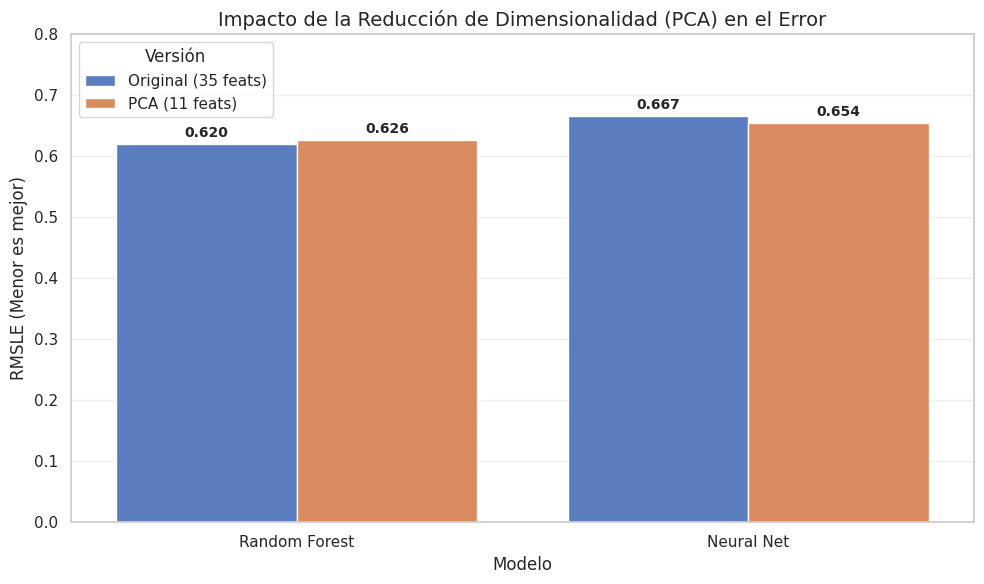

In [ ]:
print("=" * 70)
print("COMPARACIÓN VISUAL: ORIGINAL VS PCA")
print("=" * 70)

# Preparar datos para comparación
data_comparison = {"Modelo": [], "Versión": [], "RMSLE": []}

for name in top_2_names:
    score_orig = ranking.loc[name]["RMSLE"]
    data_comparison["Modelo"].append(name)
    data_comparison["Versión"].append("Original (35 feats)")
    data_comparison["RMSLE"].append(score_orig)

for index, row in df_res_pca.iterrows():
    clean_name = row["Modelo"].replace(" (PCA)", "")
    data_comparison["Modelo"].append(clean_name)
    data_comparison["Versión"].append(f'PCA ({row["Dimensiones"]} feats)')
    data_comparison["RMSLE"].append(row["RMSLE Promedio"])

df_plot = pd.DataFrame(data_comparison)

# Crear gráfico de barras comparativo
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Modelo", y="RMSLE", hue="Versión", palette="muted")

plt.title("Impacto de la Reducción de Dimensionalidad (PCA) en el Error", fontsize=14)
plt.ylabel("RMSLE (Menor es mejor)", fontsize=12)
plt.ylim(0, df_plot["RMSLE"].max() * 1.2)

# Añadir etiquetas de valor sobre las barras
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 8),
            textcoords="offset points",
            fontsize=10,
            weight="bold",
        )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Matriz de errores por droga (heatmap)

Este bloque calcula el RMSLE individual por cada droga y por cada modelo entrenado con PCA.  
Primero genera las predicciones para cada modelo, luego evalúa el error droga por droga, y organiza los resultados en un DataFrame.  
Finalmente construye un heatmap donde las filas son los modelos y las columnas las drogas, permitiendo comparar visualmente en cuáles sustancias cada modelo tiene mejor o peor desempeño.


MATRIZ DE ERRORES POR DROGA (HEATMAP)


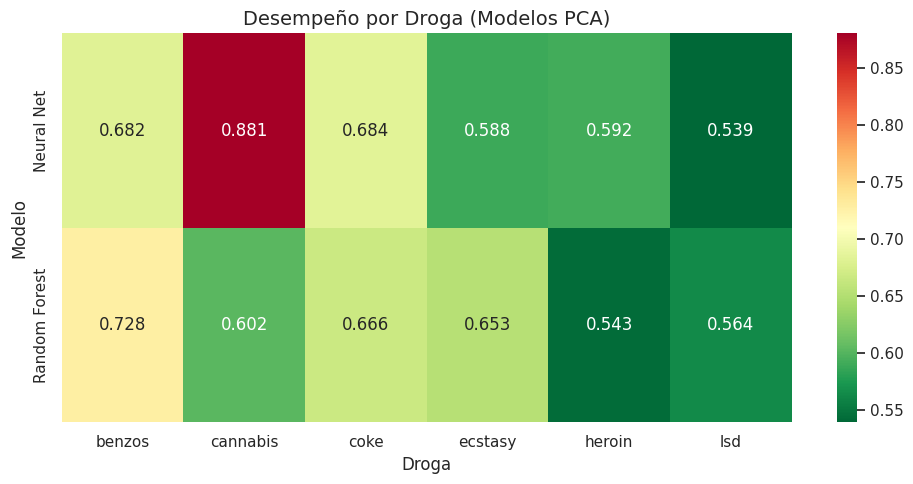

In [ ]:
print("=" * 70)
print("MATRIZ DE ERRORES POR DROGA (HEATMAP)")
print("=" * 70)

error_matrix = []

for name, model in models_pca.items():
    # Generar predicciones
    if "Neural Net" in name:
        with torch.no_grad():
            out = model(torch.FloatTensor(X_test_pca).to(device))
            preds = {d: out[d].view(-1).cpu().numpy() for d in drugs}
    else:
        p = model.predict(X_test_pca)
        preds = {d: p[:, i] for i, d in enumerate(drugs)}

    # Calcular error por droga
    for d in drugs:
        y_true = y_test[f"target_{d}"].values
        y_p = np.clip(preds[d], 0, 6)
        err = np.sqrt(mean_squared_log_error(y_true, y_p))
        error_matrix.append({"Modelo": name, "Droga": d, "RMSLE": err})

df_heatmap = pd.DataFrame(error_matrix)

# Crear heatmap
plt.figure(figsize=(10, 5))
pivot_table = df_heatmap.pivot(index="Modelo", columns="Droga", values="RMSLE")
sns.heatmap(pivot_table, annot=True, cmap="RdYlGn_r", fmt=".3f")
plt.title("Desempeño por Droga (Modelos PCA)", fontsize=14)
plt.tight_layout()
plt.show()

### Visualización 3D en espacio PCA


Este bloque genera una gráfica 3D que muestra cómo el modelo predice el riesgo de consumo para una droga específica dentro del espacio reducido por PCA.  

Primero se toma el mejor modelo y la droga objetivo, luego se obtienen las predicciones y se usan las dos primeras componentes principales como ejes X y Y.  

La altura (Z) representa la predicción del modelo, mientras que el color indica el valor real, permitiendo visualizar la relación entre el espacio PCA y la superficie de decisión del modelo.


VISUALIZACIÓN 3D: SUPERFICIE DE DECISIÓN EN ESPACIO PCA

Modelo seleccionado: Random Forest
Droga objetivo: heroin


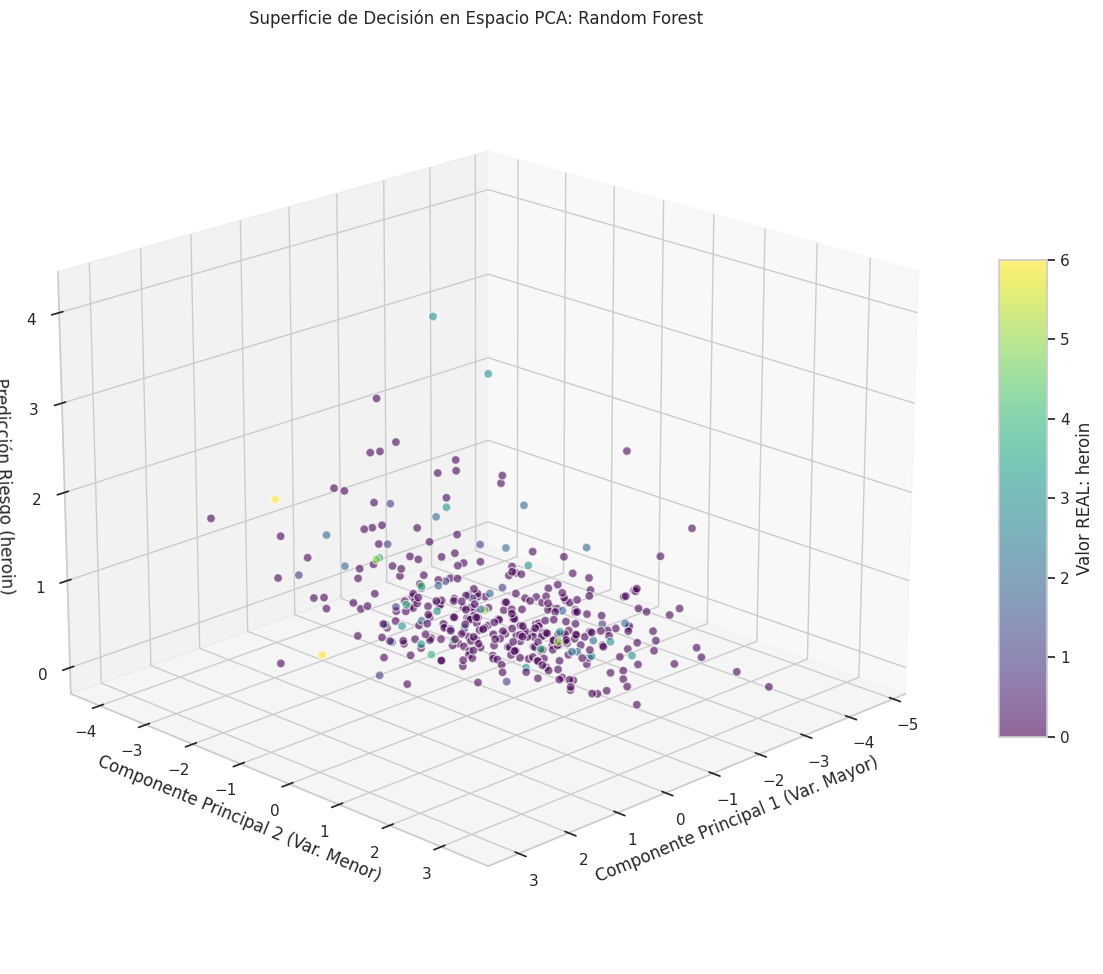

In [ ]:
print("=" * 70)
print("VISUALIZACIÓN 3D: SUPERFICIE DE DECISIÓN EN ESPACIO PCA")
print("=" * 70)

# Preparación de datos
best_model_name = list(models_pca.keys())[0]
best_model = models_pca[best_model_name]
target_drug = "heroin"

print(f"\nModelo seleccionado: {best_model_name}")
print(f"Droga objetivo: {target_drug}")

# Obtener predicciones
if "Neural Net" in best_model_name:
    with torch.no_grad():
        pred_vals = (
            best_model(torch.FloatTensor(X_test_pca).to(device))[target_drug]
            .view(-1)
            .cpu()
            .numpy()
        )
else:
    idx_drug = drugs.index(target_drug)
    pred_vals = best_model.predict(X_test_pca)[:, idx_drug]

real_vals = y_test[f"target_{target_drug}"].values

# Crear gráfico 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Usar las 2 primeras componentes del PCA para X e Y
xs = X_test_pca[:, 0]  # Componente Principal 1
ys = X_test_pca[:, 1]  # Componente Principal 2
zs = pred_vals          # Predicción (Altura)

# Scatter plot con color indicando valores reales
img = ax.scatter(
    xs, ys, zs, c=real_vals, cmap="viridis", s=40, alpha=0.6, edgecolors="w"
)

# Etiquetas y título
ax.set_xlabel("Componente Principal 1 (Var. Mayor)")
ax.set_ylabel("Componente Principal 2 (Var. Menor)")
ax.set_zlabel(f"Predicción Riesgo ({target_drug})")
ax.set_title(f"Superficie de Decisión en Espacio PCA: {best_model_name}")

# Barra de color
cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=10)
cbar.set_label(f"Valor REAL: {target_drug}")

# Ajuste de vista inicial
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

print("=" * 70)
print("VISUALIZACIÓN 3D INTERACTIVA CON PLOTLY")
print("=" * 70)

# Crear dataframe para plotly
df_3d = pd.DataFrame(
    {
        "PC1": X_test_pca[:, 0],
        "PC2": X_test_pca[:, 1],
        "Prediccion": pred_vals,
        "Realidad": real_vals,
    }
)

# Crear gráfico 3D interactivo
fig = px.scatter_3d(
    df_3d,
    x="PC1",
    y="PC2",
    z="Prediccion",
    color="Realidad",
    title=f"Espacio PCA 3D - {best_model_name} ({target_drug})",
    opacity=0.7,
    color_continuous_scale="Viridis",
)

fig.show()

print("\nGráfico interactivo generado. Puedes rotar y hacer zoom.")

VISUALIZACIÓN 3D INTERACTIVA CON PLOTLY



Gráfico interactivo generado. Puedes rotar y hacer zoom.


## 6. Reducción de Dimensionalidad con UMAP


### 6.1. Entrenamiento y Evaluación de Modelos con UMAP

In [ ]:
print("=" * 70)
print("REDUCCIÓN DE DIMENSIONALIDAD CON UMAP")
print("=" * 70)

N_COMPONENTES_UMAP = 10

print(f"\nEntrenando UMAP para reducir a {N_COMPONENTES_UMAP} dimensiones...")
print("Este proceso puede tardar varios minutos...")

reducer = umap.UMAP(
    n_components=N_COMPONENTES_UMAP,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
    n_jobs=-1,
)

X_train_umap = reducer.fit_transform(X_train_bal_proc)
X_test_umap = reducer.transform(X_test_proc)

print(f"\nTransformación completada:")
print(f"  - Train UMAP: {X_train_umap.shape}")
print(f"  - Test UMAP:  {X_test_umap.shape}")

# Selección de modelos top 2
top_2_names = ranking.index[:2].tolist()
print(f"\nRe-entrenando modelos ganadores: {top_2_names}")

models_umap = {}

for name in top_2_names:
    if "Random Forest" in name:
        models_umap[name] = RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        )
    elif "Ridge" in name:
        models_umap[name] = Ridge(alpha=1.0)
    elif "SVR" in name:
        models_umap[name] = MultiOutputRegressor(SVR(kernel="rbf", C=1.0, epsilon=0.1))
    elif "KNN" in name:
        models_umap[name] = KNeighborsRegressor(n_neighbors=5)
    elif "Neural Net" in name:
        print(f"  Configurando Red Neuronal para input_dim={N_COMPONENTES_UMAP}")
        models_umap[name] = RobustMultiTaskRegressor(input_dim=N_COMPONENTES_UMAP).to(
            device
        )

# Entrenamiento y evaluación
results_umap = []

for name, model in models_umap.items():
    print(f"\nEntrenando {name}...")

    y_train_array = y_train_bal[[f"target_{d}" for d in drugs]].values

    if name == "Neural Net":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        X_t = torch.FloatTensor(X_train_umap).to(device)
        y_t_dict = {
            d: torch.FloatTensor(y_train_bal[f"target_{d}"].values).to(device)
            for d in drugs
        }

        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(X_t)
            loss = sum([criterion(out[d], y_t_dict[d]) for d in drugs])
            loss.backward()
            optimizer.step()
        model.eval()
    else:
        model.fit(X_train_umap, y_train_array)

    print(f"  Evaluando...")

    # Predicción
    preds_dict = {}
    if name == "Neural Net":
        with torch.no_grad():
            X_test_t = torch.FloatTensor(X_test_umap).to(device)
            out = model(X_test_t)
            for d in drugs:
                preds_dict[d] = out[d].view(-1).cpu().numpy()
    else:
        preds = model.predict(X_test_umap)
        for i, d in enumerate(drugs):
            preds_dict[d] = preds[:, i]

    # Cálculo de métricas
    model_rmsles = []
    for d in drugs:
        y_true = y_test[f"target_{d}"].values
        y_pred = np.clip(preds_dict[d], 0, 6)
        rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
        model_rmsles.append(rmsle)

    avg_rmsle = np.mean(model_rmsles)

    n_orig = X_train_proc.shape[1]
    results_umap.append(
        {
            "Modelo": f"{name} (UMAP)",
            "RMSLE Promedio": avg_rmsle,
            "Dimensiones": N_COMPONENTES_UMAP,
            "Reducción %": f"{(1 - N_COMPONENTES_UMAP/n_orig)*100:.1f}%",
        }
    )

df_res_umap = pd.DataFrame(results_umap)

print("\n" + "=" * 70)
print(f"RESULTADOS CON UMAP ({N_COMPONENTES_UMAP} Componentes)")
print("=" * 70)
print(df_res_umap.to_string(index=False))
print("=" * 70)

REDUCCIÓN DE DIMENSIONALIDAD CON UMAP

Entrenando UMAP para reducir a 10 dimensiones...
Este proceso puede tardar varios minutos...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Transformación completada:
  - Train UMAP: (8988, 10)
  - Test UMAP:  (377, 10)

Re-entrenando modelos ganadores: ['Random Forest', 'Neural Net']
  Configurando Red Neuronal para input_dim=10

Entrenando Random Forest...
  Evaluando...

Entrenando Neural Net...
  Evaluando...

RESULTADOS CON UMAP (10 Componentes)
              Modelo  RMSLE Promedio  Dimensiones Reducción %
Random Forest (UMAP)        0.761630           10       69.7%
   Neural Net (UMAP)        0.684181           10       69.7%


### Análisis de influencia de variables en el espacio UMAP

Este bloque calcula qué tan fuertemente cada característica original influye en la forma del espacio reducido por UMAP.  

Para ello se convierte cada variable (incluidas las categóricas) en valores numéricos y se calcula la correlación de Spearman entre cada característica y cada dimensión del UMAP.

Luego se obtiene, para cada variable, la correlación máxima encontrada y se clasifica como influencia nula, baja o alta.

El resultado permite identificar qué variables realmente estructuran el mapa y cuáles no aportan información relevante para la organización del espacio UMAP.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

print("=" * 70)
print("ANÁLISIS DE INFLUENCIA EN UMAP (VARIABLES ORIGINALES)")
print("=" * 70)

df_analysis = X_train_bal.copy()

categorical_cols = ["gender", "education", "country", "ethnicity"]
if "impuslive" in df_analysis.columns:
    df_analysis = df_analysis.rename(columns={"impuslive": "impulsiveness"})

le = LabelEncoder()
for col in df_analysis.columns:
    if df_analysis[col].dtype == 'object' or col in categorical_cols:
        df_analysis[col] = le.fit_transform(df_analysis[col].astype(str))

feature_names_orig = df_analysis.columns.tolist()

print("Calculando correlaciones con variables originales...")
correlations = []

# Muestreo para velocidad (manteniendo alineación entre datos y UMAP)
sample_size = min(5000, df_analysis.shape[0])
idx = np.random.choice(df_analysis.shape[0], size=sample_size, replace=False)

# Extraer muestras alineadas
X_sample_orig = df_analysis.iloc[idx].values
U_sample = X_train_umap[idx]

for i, feat_name in enumerate(feature_names_orig):
    max_corr = 0
    # Comparamos la variable original contra cada dimensión del UMAP
    for j in range(U_sample.shape[1]):
        # Spearman captura relaciones no lineales (curvas)
        corr, _ = spearmanr(X_sample_orig[:, i], U_sample[:, j])
        if abs(corr) > max_corr:
            max_corr = abs(corr)

    correlations.append({"Característica": feat_name, "Influencia (Max Corr)": max_corr})

# 4. Crear Tabla
df_umap_influence = pd.DataFrame(correlations)
df_umap_influence = df_umap_influence.sort_values("Influencia (Max Corr)")

# Clasificar para visualización
def clasificar_influencia(val):
    if val < 0.15: return "Nula (Ignorada)"
    if val < 0.4: return "Baja"
    return "Alta (Estructural)"

df_umap_influence["Estado"] = df_umap_influence["Influencia (Max Corr)"].apply(clasificar_influencia)

# 5. Resultados
print("\nVARIABLES QUE UMAP NO LOGRÓ CAPTURAR (BAJA INFLUENCIA):")
print("(El mapa no se organizó siguiendo estos patrones)")
print("-" * 70)
print(df_umap_influence.head(10).to_string(index=False))

print("\n" + "-" * 70)
print("VARIABLES QUE DEFINIERON LA FORMA DEL MAPA (ALTA INFLUENCIA):")
print("-" * 70)
print(df_umap_influence.tail(8).sort_values("Influencia (Max Corr)", ascending=False).to_string(index=False))

ANÁLISIS DE INFLUENCIA EN UMAP (VARIABLES ORIGINALES)
Calculando correlaciones con variables originales...

VARIABLES QUE UMAP NO LOGRÓ CAPTURAR (BAJA INFLUENCIA):
(El mapa no se organizó siguiendo estos patrones)
----------------------------------------------------------------------
   Característica  Influencia (Max Corr) Estado
    agreeableness               0.171267   Baja
        ethnicity               0.184536   Baja
    impulsiveness               0.212651   Baja
sensation_seeking               0.219942   Baja
              age               0.225027   Baja
           gender               0.236962   Baja
     extraversion               0.245726   Baja
          country               0.254833   Baja
        education               0.256524   Baja
conscientiousness               0.285816   Baja

----------------------------------------------------------------------
VARIABLES QUE DEFINIERON LA FORMA DEL MAPA (ALTA INFLUENCIA):
-----------------------------------------------------

### Análisis gráfico de influencia de variables en el espacio UMAP

Este análisis estima qué tanto cada característica original contribuye a la estructura del espacio generado por UMAP.  
Para ello, todas las variables (incluidas las categóricas) se transforman a valores numéricos y se calcula la correlación de Spearman entre cada característica y cada una de las dimensiones del UMAP.  
Luego se selecciona la correlación máxima por variable y se clasifica como dominancia estructural, influencia media o ruido.

La gráfica resultante muestra, de forma ordenada, qué variables realmente moldean el mapa UMAP y cuáles apenas tienen impacto en su organización.


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 70)
print("ANÁLISIS GRÁFICO DE INFLUENCIA EN UMAP")
print("=" * 70)

df_analysis = X_train_bal.copy()
categorical_cols = ["gender", "education", "country", "ethnicity"]
if "impuslive" in df_analysis.columns:
    df_analysis = df_analysis.rename(columns={"impuslive": "impulsiveness"})

le = LabelEncoder()
for col in df_analysis.columns:
    if df_analysis[col].dtype == 'object' or col in categorical_cols:
        df_analysis[col] = le.fit_transform(df_analysis[col].astype(str))

feature_names_orig = df_analysis.columns.tolist()

print("Calculando correlaciones...")
correlations = []
sample_size = min(5000, df_analysis.shape[0])
idx = np.random.choice(df_analysis.shape[0], size=sample_size, replace=False)

X_sample_orig = df_analysis.iloc[idx].values
U_sample = X_train_umap[idx]

for i, feat_name in enumerate(feature_names_orig):
    max_corr = 0
    for j in range(U_sample.shape[1]):
        corr, _ = spearmanr(X_sample_orig[:, i], U_sample[:, j])
        if abs(corr) > max_corr:
            max_corr = abs(corr)
    correlations.append({"Característica": feat_name, "Influencia": max_corr})

df_umap_influence = pd.DataFrame(correlations)
df_umap_influence = df_umap_influence.sort_values("Influencia", ascending=False) # Ordenar descendente para la gráfica

def clasificar_influencia(val):
    if val < 0.15: return "Ignorada (Ruido)"
    if val < 0.35: return "Influencia Media" # Ajusté un poco el umbral visual
    return "Dominante (Estructural)"

df_umap_influence["Estado"] = df_umap_influence["Influencia"].apply(clasificar_influencia)


ANÁLISIS GRÁFICO DE INFLUENCIA EN UMAP
Calculando correlaciones...


### Radiografía del UMAP: matriz completa de correlaciones

Este análisis muestra cómo cada variable original se proyecta dentro de cada componente del UMAP.  
Para lograrlo se calcula la correlación de Spearman entre cada característica y cada dimensión del UMAP, construyendo una matriz **variable × componente**.

El heatmap resultante permite ver:

- **Qué variables tienen mayor presencia en el mapa** (filas con intensidades fuertes).
- **En qué componentes del UMAP influyen más**.
- **Qué variables fueron prácticamente ignoradas** (correlaciones cercanas a cero).

Esta matriz ofrece la vista más detallada del “mapa interno” del UMAP y de cómo organiza los datos.


RADIOGRAFÍA DEL UMAP: MATRIZ DE CORRELACIONES
Calculando matriz completa de correlaciones...

Generando mapa de calor...


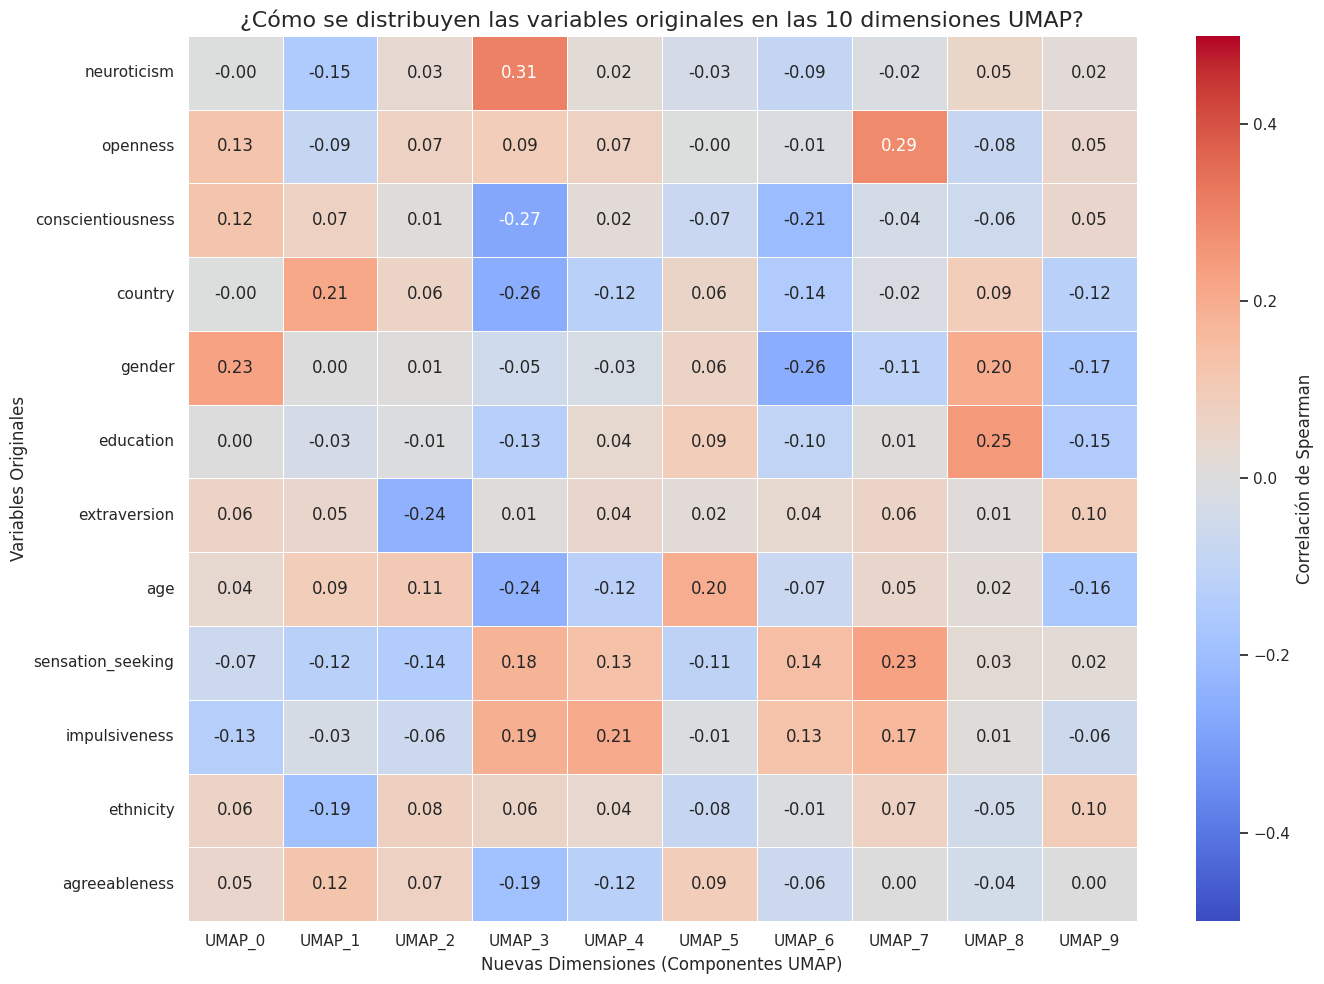

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

print("=" * 70)
print("RADIOGRAFÍA DEL UMAP: MATRIZ DE CORRELACIONES")
print("=" * 70)

n_components = U_sample.shape[1]
correlation_matrix = np.zeros((len(feature_names_orig), n_components))

print("Calculando matriz completa de correlaciones...")

for i in range(len(feature_names_orig)):
    for j in range(n_components):
        # Calculamos la correlación entre la variable i y el componente UMAP j
        corr, _ = spearmanr(X_sample_orig[:, i], U_sample[:, j])
        correlation_matrix[i, j] = corr

df_corr_matrix = pd.DataFrame(
    correlation_matrix,
    index=feature_names_orig,
    columns=[f"UMAP_{j}" for j in range(n_components)]
)

# Ordenamos las filas por la influencia máxima para que las importantes queden arriba
df_corr_matrix["Max_Abs"] = df_corr_matrix.abs().max(axis=1)
df_corr_matrix = df_corr_matrix.sort_values("Max_Abs", ascending=False).drop(columns="Max_Abs")

plt.figure(figsize=(14, 10))

sns.heatmap(
    df_corr_matrix,
    annot=True,       # Mostrar números
    fmt=".2f",        # 2 decimales
    cmap="coolwarm",  # Rojo=Positivo, Azul=Negativo
    center=0,         # Blanco en 0
    vmin=-0.5, vmax=0.5, # Limitar rango para resaltar contrastes
    linewidths=0.5,
    cbar_kws={"label": "Correlación de Spearman"}
)

plt.title("¿Cómo se distribuyen las variables originales en las 10 dimensiones UMAP?", fontsize=16)
plt.xlabel("Nuevas Dimensiones (Componentes UMAP)", fontsize=12)
plt.ylabel("Variables Originales", fontsize=12)
plt.tight_layout()

print("\nGenerando mapa de calor...")
plt.show()

### Reproyección UMAP a 2D

Este bloque recalcula una nueva proyección UMAP en dos dimensiones usando los datos procesados del modelo.  
Primero verifica qué dataset preprocesado está disponible en memoria (balanceado o normal) y, luego, genera un nuevo mapa 2D con parámetros controlados (`n_neighbors=15`, `min_dist=0.1` y métrica euclidiana).

El resultado, almacenado en `embedding_2d`, es una representación comprimida del espacio de características que conserva la estructura local del dataset. Esta proyección se usa para visualizaciones, detección de patrones y análisis de estructura en el espacio reducido.


In [ ]:
import umap
import numpy as np

print("=" * 70)
print("RECALCULANDO PROYECCIÓN UMAP 2D")
print("=" * 70)

if 'X_train_bal_proc' in locals():
    data_para_umap = X_train_bal_proc
    print("Usando datos de entrenamiento balanceados (X_train_bal_proc)...")
elif 'X_train_proc' in locals():
    data_para_umap = X_train_proc
    print("Usando datos de entrenamiento normales (X_train_proc)...")
else:
    raise ValueError("ERROR: No se encuentran los datos procesados. Por favor, ejecuta primero las celdas de Preprocesamiento.")

print("Generando mapa 2D...")

reducer_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    n_jobs=-1
)

embedding_2d = reducer_2d.fit_transform(data_para_umap)


RECALCULANDO PROYECCIÓN UMAP 2D
Usando datos de entrenamiento balanceados (X_train_bal_proc)...
Generando mapa 2D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



MAPA DE GRADIENTES: ¿DÓNDE ESTÁN LOS RASGOS EN EL ESPACIO?


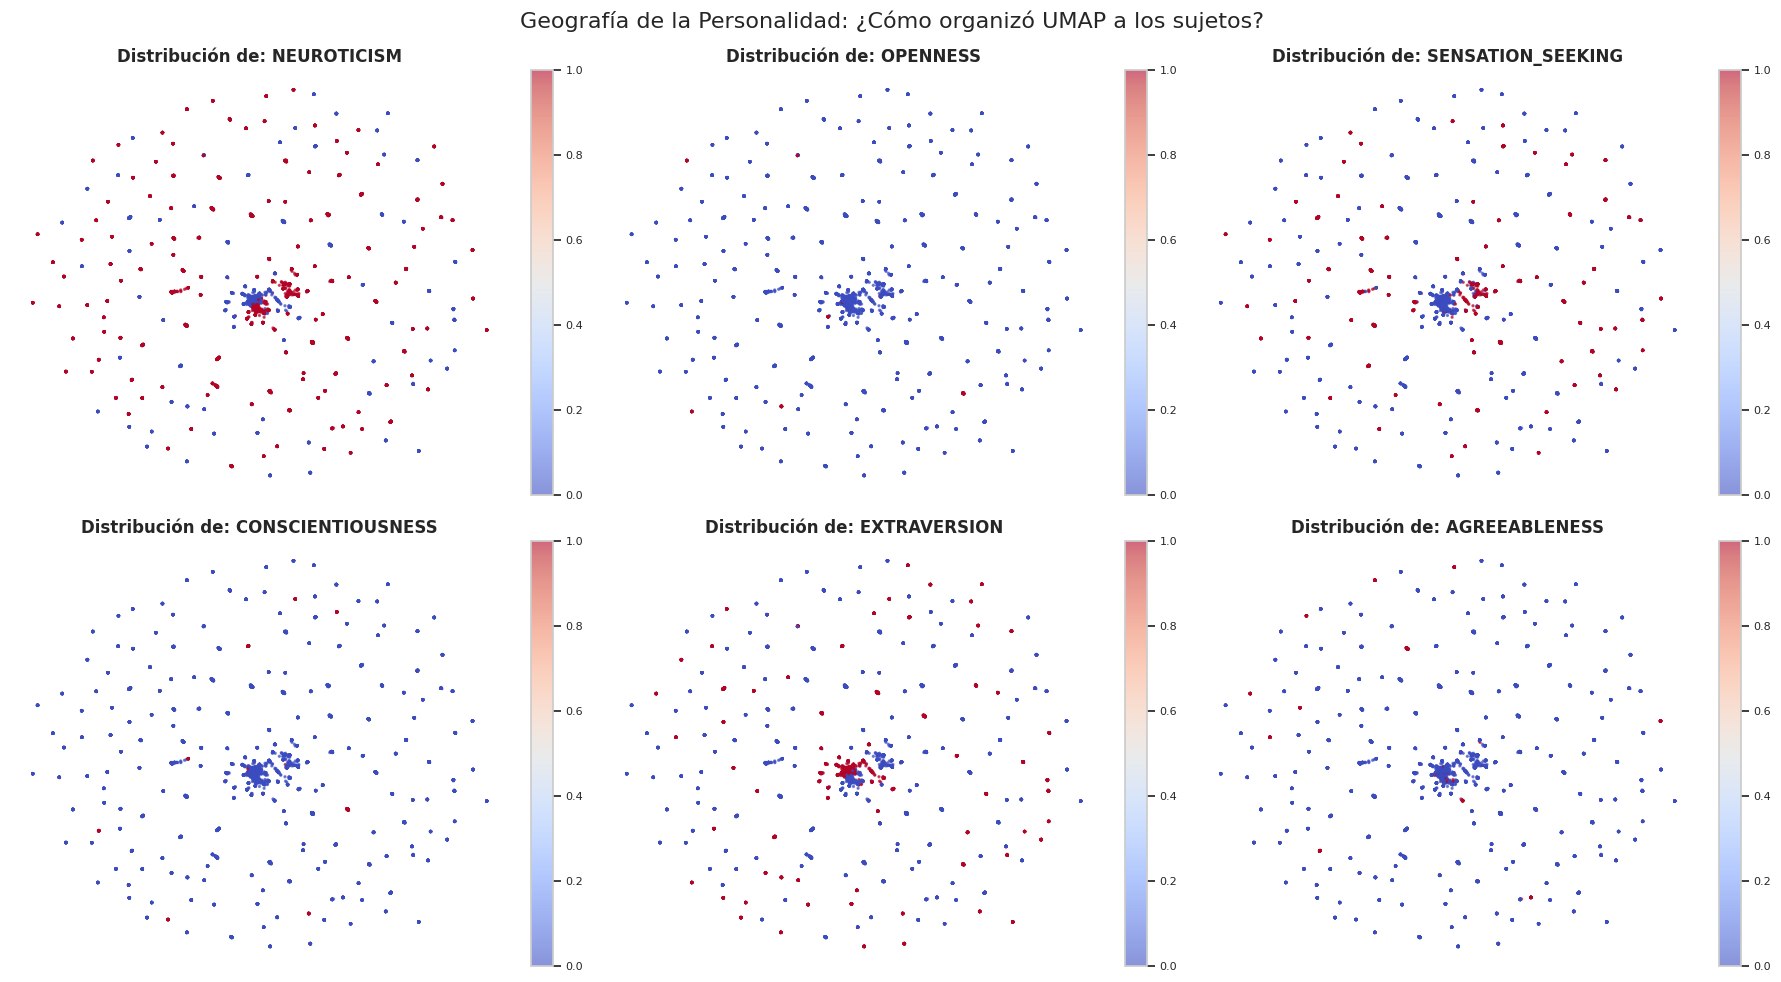

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("=" * 70)
print("MAPA DE GRADIENTES: ¿DÓNDE ESTÁN LOS RASGOS EN EL ESPACIO?")
print("=" * 70)

try:
    embedding_2d
except NameError:
    print("Recalculando proyección 2D para visualización...")
    import umap
    reducer_2d = umap.UMAP(n_components=2, random_state=42, min_dist=0.3)
    embedding_2d = reducer_2d.fit_transform(X_train_bal_proc) # O el dataset que estés usando


top_features = [
    "neuroticism",
    "openness",
    "sensation_seeking",
    "conscientiousness",
    "extraversion",
    "agreeableness"
]

# Buscar índices de estas columnas
feat_indices = []
for feat in top_features:
    try:
        idx = list(X_train_bal.columns).index(feat)
        feat_indices.append((feat, idx))
    except ValueError:
        print(f"No se encontró columna exacta para '{feat}', saltando.")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (feat_name, feat_idx) in enumerate(feat_indices):
    if i >= len(axes): break

    ax = axes[i]
    # Extraer valores de la característica (Z-scores estandarizados)
    values = X_train_bal_proc[:, feat_idx]

    # Scatter plot
    sc = ax.scatter(
        embedding_2d[:, 0],
        embedding_2d[:, 1],
        c=values,
        cmap="coolwarm",
        s=2,
        alpha=0.6
    )

    ax.set_title(f"Distribución de: {feat_name.upper()}", fontsize=12, fontweight='bold')
    ax.axis('off')

    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

plt.suptitle("Geografía de la Personalidad", fontsize=16)
plt.tight_layout()
plt.show()

### Visualización UMAP (Primeros 2 Componentes)

Esta gráfica muestra la proyección UMAP del conjunto de prueba utilizando sus dos primeras dimensiones.

Cada punto representa a un individuo y su color indica el nivel real de consumo de la droga seleccionada (`heroin`).

La visualización permite identificar patrones, agrupamientos y posibles transiciones en el comportamiento del consumo dentro del espacio reducido generado por UMAP.


VISUALIZACIÓN DE LA ESTRUCTURA UMAP (Primeros 2 Componentes)


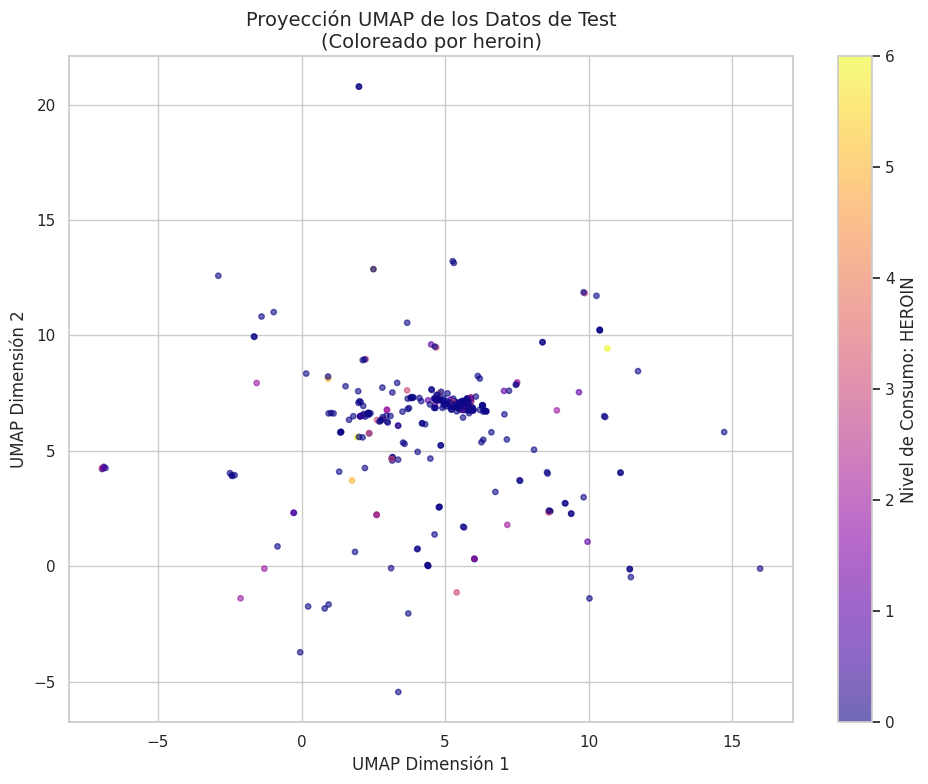

In [ ]:
print("=" * 70)
print("VISUALIZACIÓN DE LA ESTRUCTURA UMAP (Primeros 2 Componentes)")
print("=" * 70)

target_drug = "heroin"

plt.figure(figsize=(10, 8))
plt.scatter(
    X_test_umap[:, 0],
    X_test_umap[:, 1],
    c=y_test[f"target_{target_drug}"],
    cmap="plasma",
    s=15,
    alpha=0.6
)
plt.colorbar(label=f"Nivel de Consumo: {target_drug.upper()}")
plt.title(f"Proyección UMAP de los Datos de Test\n(Coloreado por {target_drug})", fontsize=14)
plt.xlabel("UMAP Dimensión 1")
plt.ylabel("UMAP Dimensión 2")
plt.tight_layout()
plt.show()

VISUALIZACIÓN 2D: PROYECCIÓN UMAP

Generando proyección 2D para visualización...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



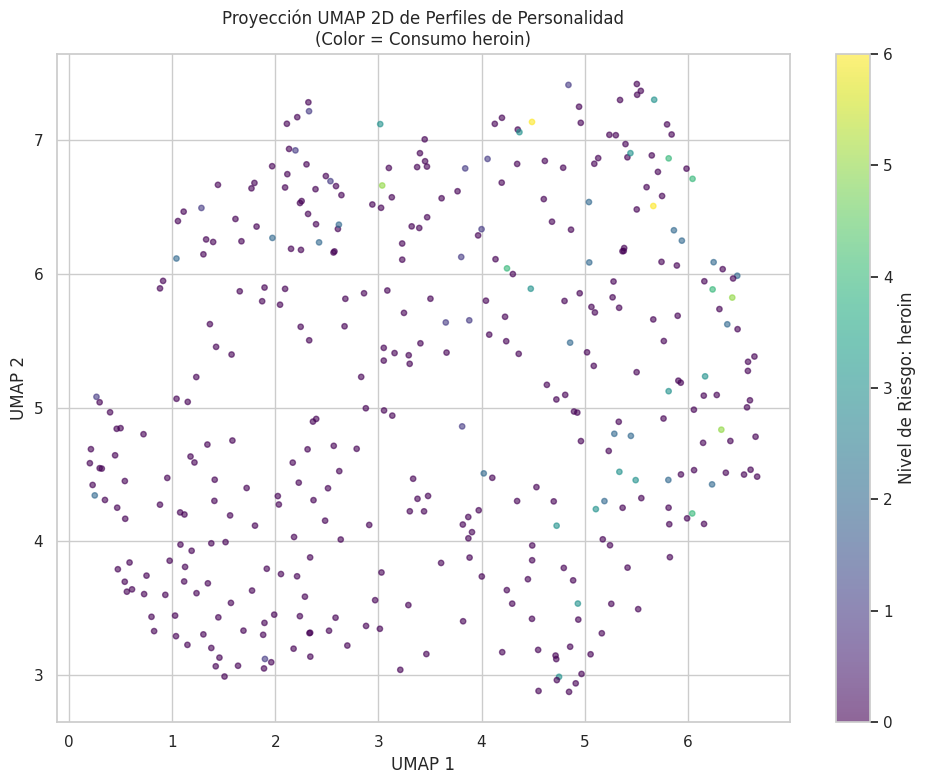


Proyección 2D completada.


In [ ]:
print("=" * 70)
print("VISUALIZACIÓN 2D: PROYECCIÓN UMAP")
print("=" * 70)

print("\nGenerando proyección 2D para visualización...")
reducer_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer_2d.fit_transform(X_test_proc)

# Coloreamos por consumo de Heroína
target_viz = "heroin"

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=y_test[f"target_{target_viz}"],
    cmap="viridis",
    s=15,
    alpha=0.6,
)
plt.colorbar(label=f"Nivel de Riesgo: {target_viz}")
plt.title(
    f"Proyección UMAP 2D de Perfiles de Personalidad\n(Color = Consumo {target_viz})"
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

print("\nProyección 2D completada.")